In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pynlo
from scipy import constants

In [2]:
from dataclasses import dataclass

@dataclass
class NobleGasData:
    name: str
    beta2: float          # [fs^2/(cm bar)]
    beta3: float          # [fs^3/(cm bar)]
    beta4: float          # [fs^4/(cm bar)]
    n2_at_one_bar: float  # [m^2/(W bar)]
    
    def __repr__(self):
        return (f"{self.name}: beta2={self.beta2} fs^2/(cm bar), "
                f"beta3={self.beta3} fs^3/(cm bar), "
                f"beta4={self.beta4} fs^4/(cm bar), "
                f"n2_at_one_bar={self.n2_at_one_bar} m^2/(W bar)")

noble_gases = [
    NobleGasData(name="Neon", beta2=0.0202, beta3=0.0158, beta4=0, n2_at_one_bar=0.14e-23),
    NobleGasData(name="Argon", beta2=0.1980, beta3=0.1586, beta4=0, n2_at_one_bar=1.74e-23),
    NobleGasData(name="Krypton", beta2=0.3996, beta3=0.3298, beta4=0, n2_at_one_bar=4.03e-23),
    NobleGasData(name="Xenon", beta2=0.9113, beta3=0.7836, beta4=0, n2_at_one_bar=11.15e-23),
]

In [3]:
def loadGasParameters(gas_name):
        noble_gases_dict = {gas.name.lower(): gas for gas in noble_gases}
        gas = noble_gases_dict.get(gas_name.lower(), f"Gas not found in noble gas data.")
        n2_at_one_bar = gas.n2_at_one_bar
        beta2 = gas.beta2 * (1e-3)**2 / 1e-5  # [ps^2/(km bar)]
        beta3 = gas.beta3 * (1e-3)**3 / 1e-5  # [ps^3/(km bar)]
        beta4 = gas.beta4 * (1e-3)**4 / 1e-5  # [ps^4/(km bar)]
        betas_at_one_bar = [beta2, beta3, beta4]
        
        return n2_at_one_bar, betas_at_one_bar    

In [4]:
class GasPropertyBuilder:
    
    def __init__(self, fiber_length, fiber_radius, fiber_wavelength, pulse_wavelength, n2_at_one_bar, betas_at_one_bar,  
                 constant_pressure=None, pressure_boundary=None, differential_pumping=False):
        
        assert (constant_pressure is not None) if not differential_pumping else True, \
        "A constant gas pressure is expected for non-differential pumping scheme."
        assert (pressure_boundary is not None) if differential_pumping else True, \
        "A list containing the boundary values of the gas pressure at both input \
        and output surface of the fiber is expected for differential pumping scheme."
        
        self.fiber_len = fiber_length
        self.fiber_rad = fiber_radius
        self.fibWL = fiber_wavelength
        self.pulseWL = pulse_wavelength
        
        if differential_pumping:
            if len(pressure_boundary) != 2:
                print("A list containing the boundary values of the gas pressure at both input \
                and output surface of the fiber is expected for differential pumping scheme.")
            self.pressure_entr = pressure_boundary[0]
            self.pressure_exit = pressure_boundary[1]
        else:
            self.const_pressure = constant_pressure
        
        self.n2_at_one_bar = n2_at_one_bar
        self.betas_at_one_bar = betas_at_one_bar
        self.differential_pumping = differential_pumping
    
    def torrToBar(self, pressure_Torr):
        """
        Unit conversion for gas pressure from torr to bar.
        
        1 torr is defined as exactly 1/760 of a standard atmosphere (1 atm = 101325 Pa), 
        1 pascal is equal to 1e-5 bar.

        Input(s):
        pressure_Torr: gas pressure [Torr]
        Output(s):
        pressure_Bar: gas pressure [Bar]
        """
        
        pressure_Pa = pressure_Torr * (101325/760)
        pressure_Bar = pressure_Pa * 1e-5
        
        return pressure_Bar

    def pressureDistribution(self, z):
        """
        Generate gas pressure distribution along the fiber under differential pumping.

        Reference: 
        Suda, Akira, et al.
        “Generation of Sub-10-Fs, 5-mJ-Optical Pulses Using a Hollow Fiber with a Pressure Gradient.”
        Applied Physics Letters, vol. 86, no. 11, 2005, https://doi.org/10.1063/1.1883706.
        
        Input(s):
        z: position grid along the fiber [m].
        fiber_len: length of the fiber [m].
        pressure_entr: gas pressure at the entrance [Torr].
        pressure_exit: gas pressure at the exit [Torr].
        Output(s):
        pressure_dist: gas pressure distribution along the fiber [Bar].
        """
        
        pressure_entr = self.torrToBar(self.pressure_entr)
        pressure_exit = self.torrToBar(self.pressure_exit)
        pressure_dist = np.sqrt(pressure_entr**2 + (z/self.fiber_len) * (pressure_exit**2 - pressure_entr**2))
        
        return pressure_dist
        
    def dispersionFunction(self, z):
        """
        Generate the fiber dispersion that can vary as a function of the length z along the fiber 
        for differential pumping, return a tuple of beta coefficients as a function of z.
        
        Input(s):
        pressure_dist: gas pressure distribution along the fiber [Bar].
        betas_at_one_bar: a list of beta coefficients (i.e. [beta2, beta3, beta4]) specified at 1 bar [ps^n/km].
        Output(s):
        betas: a tuple of beta coefficients as a function of z [ps^n/m].
        """
        
        betas = []
        pressure_dist = self.pressureDistribution(z)
        for beta in self.betas_at_one_bar:
            betas.append(beta * (1/1e3) * pressure_dist)
        
        return tuple(betas)
    
    def nonlinearIndexN2(self, z=None):
        """
        Calculate the nonlinear refractive index n2, return a constant for non-differential pumping, 
        or a distribution along the fiber for differential pumping.

        Input(s):
        pressure_dist: gas pressure distribution along the fiber under differential pumping [Bar].
        const_pressure: constant gas pressure for non-differential pumping [Bar].
        n2_at_one_bar: nonlinear refractive index of the gas reported at 1 bar [m^2/(W bar)].
        Output(s):
        n2: nonlinear refractive index at the specified pressure [m^2/W].
        """
        
        assert (z is None) if not self.differential_pumping else True, \
        "A position grid is not needed for non-differential pumping."
        assert (z is not None) if self.differential_pumping else True, \
        "A position grid is needed for differential pumping."
        
        if self.differential_pumping:
            pressure_dist = self.pressureDistribution(z)
            n2 = pressure_dist * self.n2_at_one_bar
        else:
            const_pressure = self.torrToBar(self.const_pressure)
            n2 = const_pressure * self.n2_at_one_bar
        
        return n2
        
    def gammaDistribution(self, z=None):
        """
        Calculate the nonlinear parameter Gamma using Gamma=(n2*w0)/(c*A_eff), return a constant 
        for non-differential pumping, or a distribution along the fiber for differential pumping. 
        Reference: Agrawal, Govind. Nonlinear Fiber Optics. Sixth edition., Academic Press, 2019.
        
        c: speed of light in vacuum [m/s].
        w0: angular frequency [rad/s].
        A_eff: effective core area of the fiber [m^2].

        Input(s):
        n2: nonlinear refractive index at the specified pressure [m^2/W].
        pulseWL: pulse central wavelength [nm].
        fiber_rad: radius of fiber [m].
        Output(s):
        Gamma: nonlinear parameter [1/(W m)]
        """
        
        assert (z is None) if not self.differential_pumping else True, \
        "A position grid is not needed for non-differential pumping."
        assert (z is not None) if self.differential_pumping else True, \
        "A position grid is needed for differential pumping."
        
        w0 = (2*np.pi*constants.c) / (self.pulseWL*1e-9)
        A_eff = np.pi * self.fiber_rad**2
        n2 = self.nonlinearIndexN2(z)
        Gamma = (n2*w0) / (constants.c*A_eff)
        
        return Gamma

In [5]:
def photonEnergyGrid(pulse):
    """
    Convert the grid corresponding to the complex electric field in frequency
    domain from angular frequency to photon energy in eV.
    
    Photon energy:
    E[J] = hbar*w = (h*w)/(2pi) = hv
    E[eV] = E[J]/e
    
    Input(s):
    pulse: a pulse instance on which the conversion is performed.
    Output(s):
    W_eV: photon energy grid [eV].
    """
    
    W_eV = constants.h * (pulse.W_mks / (2*np.pi)) / constants.e
    
    return W_eV

In [6]:
def spectralPowerDensity(intensity_dB, reference_pulse, fiber_radius):
    """
    Derive the spectral power density for the output pulse from its intensity data.
    
    Input(s):
    intensity_dB: a 2D numpy array corresponding to the intensities in decibels in each frequency bin 
                  for each step in the z-direction of the fiber, it has a shape of (steps, grid size).
    reference_pulse: a pulse instance on which the reference intensity calculation is based.
    Output(s):
    spectral_power_density: spectral power density for the output pulse [W/eV].
    """
    
    A_eff = np.pi * fiber_radius**2  # effective area of fiber [m^2]
    
    # calculate the average power of the reference pulse based on its repetition rate
    # and energy per pulse
    P_ref = pulse.calc_epp() * pulse.frep_mks  # average power [W]
    I_ref = P_ref / A_eff  # reference intensity [W/m^2]
    
    I = I_ref * 10**(intensity_dB/10)  # output pulse intensity [W/m^2]
    spectral_power_density = I * A_eff  # [W]
    
    return spectral_power_density

In [12]:
def calculateOutputFrequencyLimit(frequency_limit, simulation_window, simulation_points):
    """
    Calculate the upper limit on the output frequency of the output pulse.
    
    Inputs:
    simulation_window: total time window of the simulation in picoseconds [ps]
    simulation_points: number of steps the simulation takes as the pulse propagates through the fiber
    
    Outputs:
    output_frequency_limit: upper limit on the frequency of the output pulse in THz [THz]
    """
    
    if frequency_limit is None:
        frequency_limit = 0.5 * simulation_points / simulation_window
        
    if simulation_points is None:
        simulation_points = 2 * simulation_window * frequency_limit
    if simulation_window is None:
        simulation_window = 0.5 * simulation_points / frequency_limit
    
    return frequency_limit, simulation_window, simulation_points


In [13]:
# Planck's constant in eV/Hz
h_ev_hz = constants.physical_constants['Planck constant in eV/Hz'][0]

$\eta_{SHG} = \frac{E_{2\omega}}{E_\omega} = 0.2$ leads to $5E_{2\omega} = E_\omega$

$E_\omega + E_{2\omega} = E_{\omega}^{(0)}$ gives $\frac{6}{5}E_\omega = E_{\omega}^{(0)}$

Hence, we obtain $E_\omega = \frac{5}{6} E_{\omega}^{(0)}$ and $E_{2\omega} = \frac{1}{6} E_{\omega}^{(0)}$

More generally, $ E_{2\omega} = \eta_{SHG} E_\omega $

$(1+\eta_{SHG}) E_\omega = E_{\omega}^{(0)}$

$E_\omega = \frac{1}{1+\eta_{SHG}} E_{\omega}^{(0)}$

$E_{2\omega} = \frac{\eta_{SHG}}{1+\eta_{SHG}} E_{\omega}^{(0)}$

For a given pulse duration and fiber radius (cross section), and a given energy, can calculate intensity that can be achieved:

$I = \frac{energy}{time \times area}$

For a given laser device, thus a given duration, the maximum energy per pulse is usually limited:
1. for a given fiber radius, this gives the maximum achievable intensity
2. for a given desired intensity to be achieved, this gives the fiber radius


### Refine the class:

In [51]:
class PeakIntensityBuilder:
    
    def __init__(self, SHG_efficiency, pulse_duration, peak_intensity_CGS=None):
        
        self.eta = SHG_efficiency
        self.FWHM = pulse_duration                                # [s]
        self.peak_intensity_CGS = peak_intensity_CGS              # [W/cm^2]
        self.peak_intensity_MKS = self.toMKS(peak_intensity_CGS)  # [W/m^2]
    
    def toMKS(self, intensity_CGS):
        """
        Unit conversion for optical intensity from W/cm^2 to W/m^2.
        
        Input(s):
        intensity_CGS: intensity [W/cm^2]
        Output(s):
        intensity_MKS: intensity [W/m^2]
        """
        intensity_MKS = intensity_CGS / (1e-2)**2
        return intensity_MKS
    
    def toCGS(self, intensity_MKS):
        """
        Unit conversion for optical intensity from W/m^2 to W/cm^2.
        
        Input(s):
        intensity_MKS: intensity [W/m^2]
        Output(s):
        intensity_CGS: intensity [W/cm^2]
        """
        intensity_CGS = intensity_MKS / (1e2)**2
        return intensity_CGS
    
    def divideEPP(self, total_EPP):
        EPP_FD = total_EPP / (1 + self.eta)
        EPP_SH = self.eta * EPP_FD
        return EPP_FD, EPP_SH
    
    def calcFiberRadius(self, total_EPP_limit):
        assert self.peak_intensity_MKS is not None, \
        "A target peak intensity must be provided to enable this function."
        EPP_FD_limit, EPP_SH_limit = self.divideEPP(total_EPP_limit)
        fiber_rad_limit = np.sqrt(EPP_SH_limit / (self.peak_intensity_MKS * self.FWHM * np.pi))
        return fiber_rad_limit
        
    def calcPeakIntensity(self, reference_EPP, fiber_radius):
        """
        Calculate the resulting peak intensity in [W/cm^2] from the given pulse energy,
        pulse duration and fiber radius.
        """
        peak_intensity_MKS = reference_EPP / (self.FWHM * np.pi * fiber_radius**2)
        peak_intensity_CGS = self.toCGS(peak_intensity_MKS)
        return peak_intensity_CGS
    
#     def calcFiberRadius(self, reference_EPP):
#         """
#         Calculate the maximum fiber radius in [m] that maintains the required peak intensity
#         for a given pulse energy and pulse duration.
#         """
#         assert self.peak_intensity_MKS is not None, \
#         "A target peak intensity must be provided to enable this function."
#         fiber_rad = np.sqrt(reference_EPP / (self.peak_intensity_MKS * self.FWHM * 1e-12 * np.pi))
#         return fiber_rad
    
    def calcEPP(self, fiber_radius):
        """
        Calculate the pulse energies in [J] that maintain the required peak intensity
        for a given fiber radius and pulse duration.
        """
        assert self.peak_intensity_MKS is not None, \
        "A target peak intensity must be provided to enable this function."
        EPP_SH = self.peak_intensity_MKS * self.FWHM * np.pi * fiber_radius**2
        EPP_FD = EPP_SH / self.eta
        total_EPP = EPP_FD + EPP_SH
        return total_EPP, EPP_FD, EPP_SH
        

In [118]:
# pulse parameters
FWHM = 0.03                # pulse duration [ps]
pulseWL = 800              # pulse central wavelength [nm]
SHG_efficiency = 0.2       # SHG conversion efficiency
total_EPP_limit = 1e-3     # pulse energy limit of laser source [J]
GDD = 0.0                  # group delay dispersion [ps^2]
TOD = 0.0                  # third order dispersion [ps^3]
peak_intensity_CGS = 2e12  # peak intensity for nonlinear processes [W/cm^2]

# fiber parameters
Length = 100    # fiber length [mm]
Alpha = 0.0     # attentuation coefficient [dB/cm]
fibWL = 800     # center wavelength of fiber [nm]
alpha = np.log((10**(Alpha * 0.1))) * 100  # convert from dB/cm to 1/m


# simulation parameters
Window = 2      # simulation window [ps]
Steps = 10        # simulation steps
Points = 2**14    # simulation points
Raman = True      # Enable Raman effect?
Steep = True      # Enable self steepening?

intensitybuilder = PeakIntensityBuilder(SHG_efficiency=SHG_efficiency, 
                                        pulse_duration=FWHM*1e-12, 
                                        peak_intensity_CGS=peak_intensity_CGS)


In [119]:
fiber_rad_limit = intensitybuilder.calcFiberRadius(total_EPP_limit=total_EPP_limit)
print(f'If a total pulse energy of {total_EPP_limit*1e3} mJ are available, \
the maximum possible fiber radius is {fiber_rad_limit*1e6:.4} microns.')

fiber_rad = np.arange(10,fiber_rad_limit*1e6,50) * 1e-6  # fiber radius [m]
print(fiber_rad)

If a total pulse energy of 1.0 mJ are available, the maximum possible fiber radius is 297.4 microns.
[1.0e-05 6.0e-05 1.1e-04 1.6e-04 2.1e-04 2.6e-04]


In [120]:
total_EPP, EPP_FD, EPP_SH = intensitybuilder.calcEPP(fiber_radius=fiber_rad)
for i in range(len(fiber_rad)):
    print(f'For fiber radius {fiber_rad[i]*1e6:.4} microns, a total of {total_EPP[i]*1e3:.4} mJ is needed, \nof which the fundamental pulse has {EPP_FD[i]*1e3:.4} mJ, \nthe second harmonic pulse has {EPP_SH[i]*1e3:.4} mJ.')
    

For fiber radius 10.0 microns, a total of 0.001131 mJ is needed, 
of which the fundamental pulse has 0.0009425 mJ, 
the second harmonic pulse has 0.0001885 mJ.
For fiber radius 60.0 microns, a total of 0.04072 mJ is needed, 
of which the fundamental pulse has 0.03393 mJ, 
the second harmonic pulse has 0.006786 mJ.
For fiber radius 110.0 microns, a total of 0.1368 mJ is needed, 
of which the fundamental pulse has 0.114 mJ, 
the second harmonic pulse has 0.02281 mJ.
For fiber radius 160.0 microns, a total of 0.2895 mJ is needed, 
of which the fundamental pulse has 0.2413 mJ, 
the second harmonic pulse has 0.04825 mJ.
For fiber radius 210.0 microns, a total of 0.4988 mJ is needed, 
of which the fundamental pulse has 0.4156 mJ, 
the second harmonic pulse has 0.08313 mJ.
For fiber radius 260.0 microns, a total of 0.7645 mJ is needed, 
of which the fundamental pulse has 0.6371 mJ, 
the second harmonic pulse has 0.1274 mJ.


In [121]:
def dB(num):
        return 10 * np.log10(np.abs(num)**2)

### Results:

Pulse energy before Simple Fiber : 1130.9733552923253 nJ
pulse energy in  2423268.4959400212
copied as   2423268.4959400212
Step: 0 Distance remaining: 0.1
Pulse energy after: 1124.5669629933798 nJ
Step: 1 Distance remaining: 0.09000000000000001
Pulse energy after: 1124.6879947633106 nJ
Step: 2 Distance remaining: 0.08000000000000002
Pulse energy after: 1123.5811100291646 nJ
Step: 3 Distance remaining: 0.06999999999999999
Pulse energy after: 1122.8852152116574 nJ
Step: 4 Distance remaining: 0.06
Pulse energy after: 1123.1515778501075 nJ
Step: 5 Distance remaining: 0.05
Pulse energy after: 1123.5360588800224 nJ
Step: 6 Distance remaining: 0.04000000000000001
Pulse energy after: 1123.4527250385372 nJ
Step: 7 Distance remaining: 0.030000000000000006
Pulse energy after: 1123.0235315151917 nJ
Step: 8 Distance remaining: 0.019999999999999997
Pulse energy after: 1122.5841160284624 nJ
Step: 9 Distance remaining: 0.009999999999999998
Pulse energy after: 1122.311415009081 nJ
Pulse energy after S

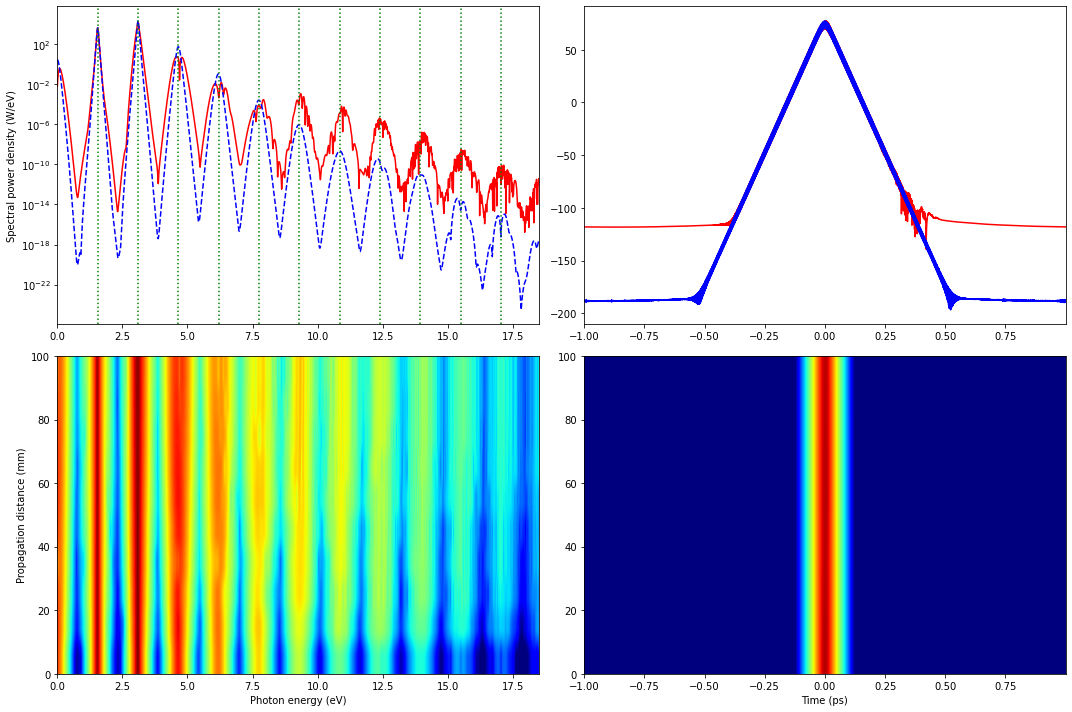

Pulse energy before Simple Fiber : 40715.04079052371 nJ
pulse energy in  14539610.975640126
copied as   14539610.975640126
Step: 0 Distance remaining: 0.1
Pulse energy after: 40484.41066776172 nJ
Step: 1 Distance remaining: 0.09000000000000001
Pulse energy after: 40488.767811479236 nJ
Step: 2 Distance remaining: 0.08000000000000002
Pulse energy after: 40448.91996104998 nJ
Step: 3 Distance remaining: 0.06999999999999999
Pulse energy after: 40423.86774761969 nJ
Step: 4 Distance remaining: 0.06
Pulse energy after: 40433.45680260391 nJ
Step: 5 Distance remaining: 0.05
Pulse energy after: 40447.29811968084 nJ
Step: 6 Distance remaining: 0.04000000000000001
Pulse energy after: 40444.298101387365 nJ
Step: 7 Distance remaining: 0.030000000000000006
Pulse energy after: 40428.84713454693 nJ
Step: 8 Distance remaining: 0.019999999999999997
Pulse energy after: 40413.02817702468 nJ
Step: 9 Distance remaining: 0.009999999999999998
Pulse energy after: 40403.21094032693 nJ
Pulse energy after Simple Fi

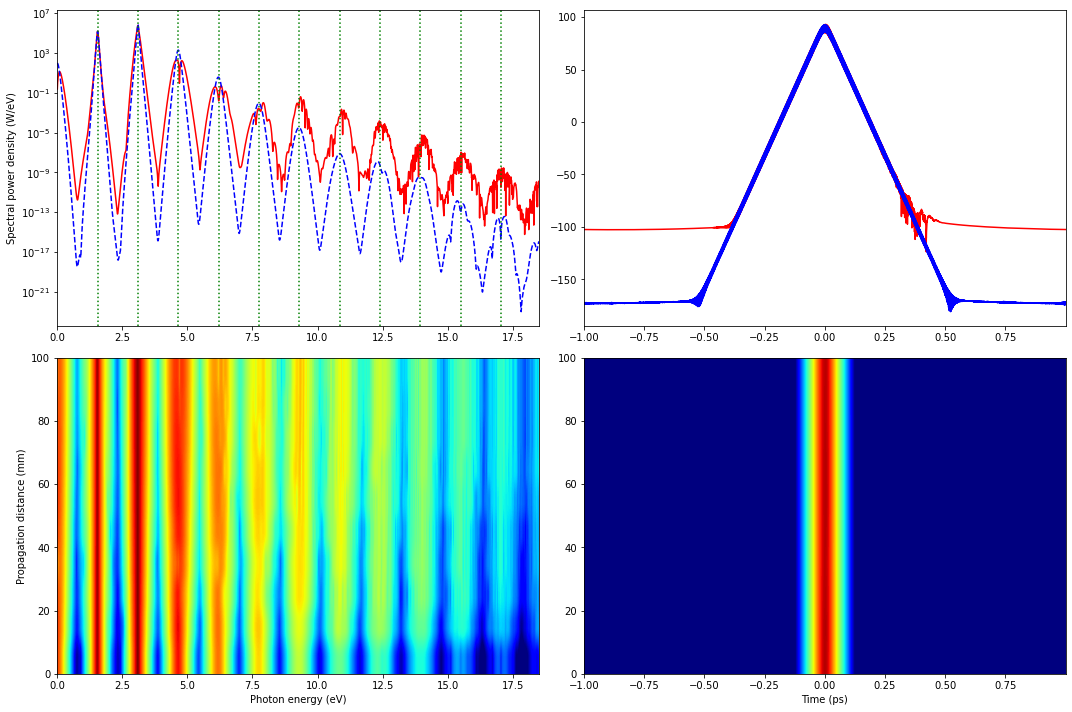

Pulse energy before Simple Fiber : 136847.77599037142 nJ
pulse energy in  26655953.45534023
copied as   26655953.45534023
Step: 0 Distance remaining: 0.1
Pulse energy after: 136072.60252219904 nJ
Step: 1 Distance remaining: 0.09000000000000001
Pulse energy after: 136087.24736636068 nJ
Step: 2 Distance remaining: 0.08000000000000002
Pulse energy after: 135953.31431352903 nJ
Step: 3 Distance remaining: 0.06999999999999999
Pulse energy after: 135869.11104061062 nJ
Step: 4 Distance remaining: 0.06
Pulse energy after: 135901.3409198631 nJ
Step: 5 Distance remaining: 0.05
Pulse energy after: 135947.86312448274 nJ
Step: 6 Distance remaining: 0.04000000000000001
Pulse energy after: 135937.7797296631 nJ
Step: 7 Distance remaining: 0.030000000000000006
Pulse energy after: 135885.84731333828 nJ
Step: 8 Distance remaining: 0.019999999999999997
Pulse energy after: 135832.67803944406 nJ
Step: 9 Distance remaining: 0.009999999999999998
Pulse energy after: 135799.68121609883 nJ
Pulse energy after Simp

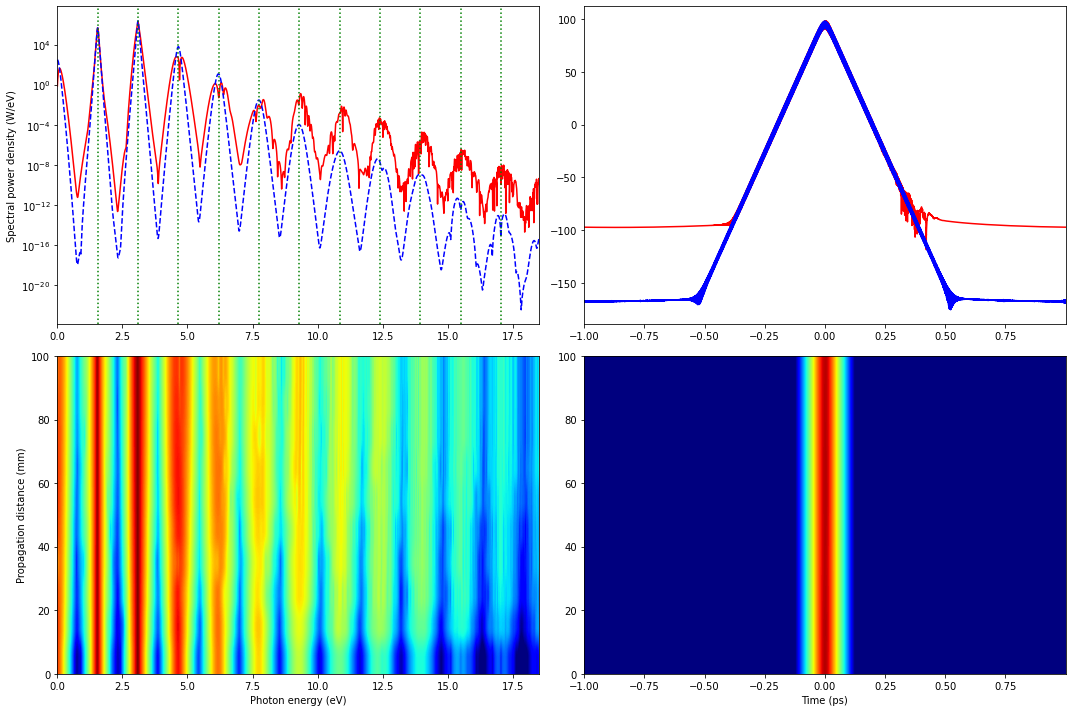

Pulse energy before Simple Fiber : 289529.1789548353 nJ
pulse energy in  38772295.93504034
copied as   38772295.93504034
Step: 0 Distance remaining: 0.1
Pulse energy after: 287889.1425263052 nJ
Step: 1 Distance remaining: 0.09000000000000001
Pulse energy after: 287920.1266594075 nJ
Step: 2 Distance remaining: 0.08000000000000002
Pulse energy after: 287636.76416746614 nJ
Step: 3 Distance remaining: 0.06999999999999999
Pulse energy after: 287458.6150941843 nJ
Step: 4 Distance remaining: 0.06
Pulse energy after: 287526.8039296275 nJ
Step: 5 Distance remaining: 0.05
Pulse energy after: 287625.23107328574 nJ
Step: 6 Distance remaining: 0.04000000000000001
Pulse energy after: 287603.8976098655 nJ
Step: 7 Distance remaining: 0.030000000000000006
Pulse energy after: 287494.0240678891 nJ
Step: 8 Distance remaining: 0.019999999999999997
Pulse energy after: 287381.5337032864 nJ
Step: 9 Distance remaining: 0.009999999999999998
Pulse energy after: 287311.72224232473 nJ
Pulse energy after Simple Fib

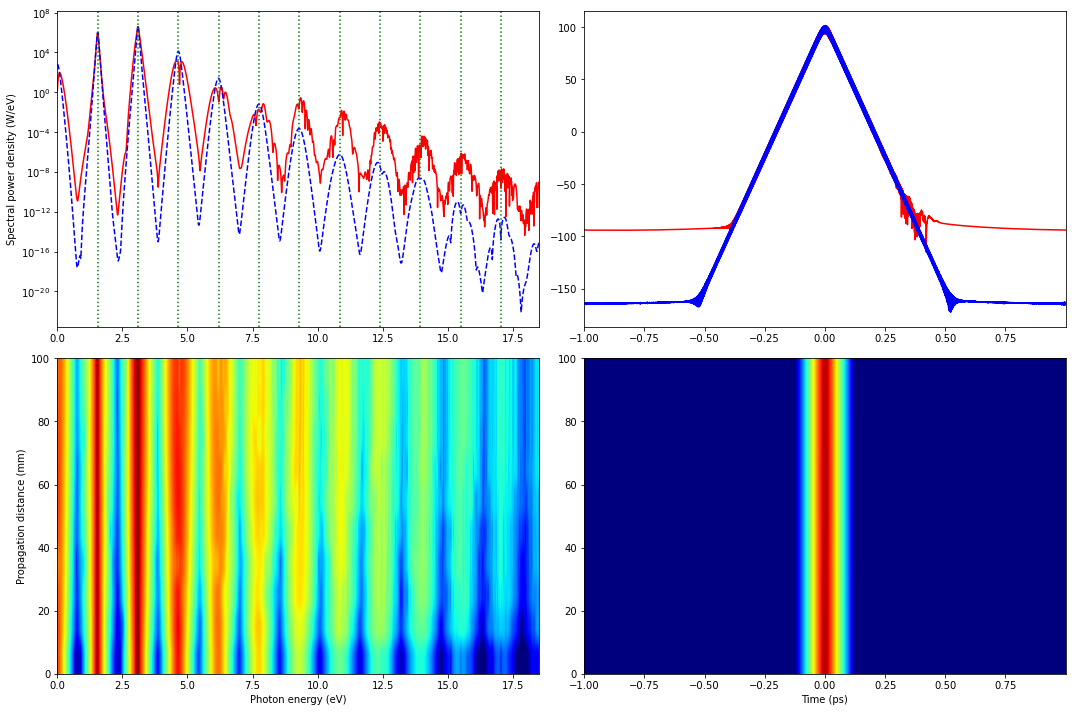

Pulse energy before Simple Fiber : 498759.24968391546 nJ
pulse energy in  50888638.41474044
copied as   50888638.41474044
Step: 0 Distance remaining: 0.1
Pulse energy after: 495934.0306800807 nJ
Step: 1 Distance remaining: 0.09000000000000001
Pulse energy after: 495987.40569062036 nJ
Step: 2 Distance remaining: 0.08000000000000002
Pulse energy after: 495499.269522862 nJ
Step: 3 Distance remaining: 0.06999999999999999
Pulse energy after: 495192.37990834133 nJ
Step: 4 Distance remaining: 0.06
Pulse energy after: 495309.84583189787 nJ
Step: 5 Distance remaining: 0.05
Pulse energy after: 495479.40196609014 nJ
Step: 6 Distance remaining: 0.04000000000000001
Pulse energy after: 495442.65174199524 nJ
Step: 7 Distance remaining: 0.030000000000000006
Pulse energy after: 495253.3773981997 nJ
Step: 8 Distance remaining: 0.019999999999999997
Pulse energy after: 495059.5951685523 nJ
Step: 9 Distance remaining: 0.009999999999999998
Pulse energy after: 494939.33401900495 nJ
Pulse energy after Simple 

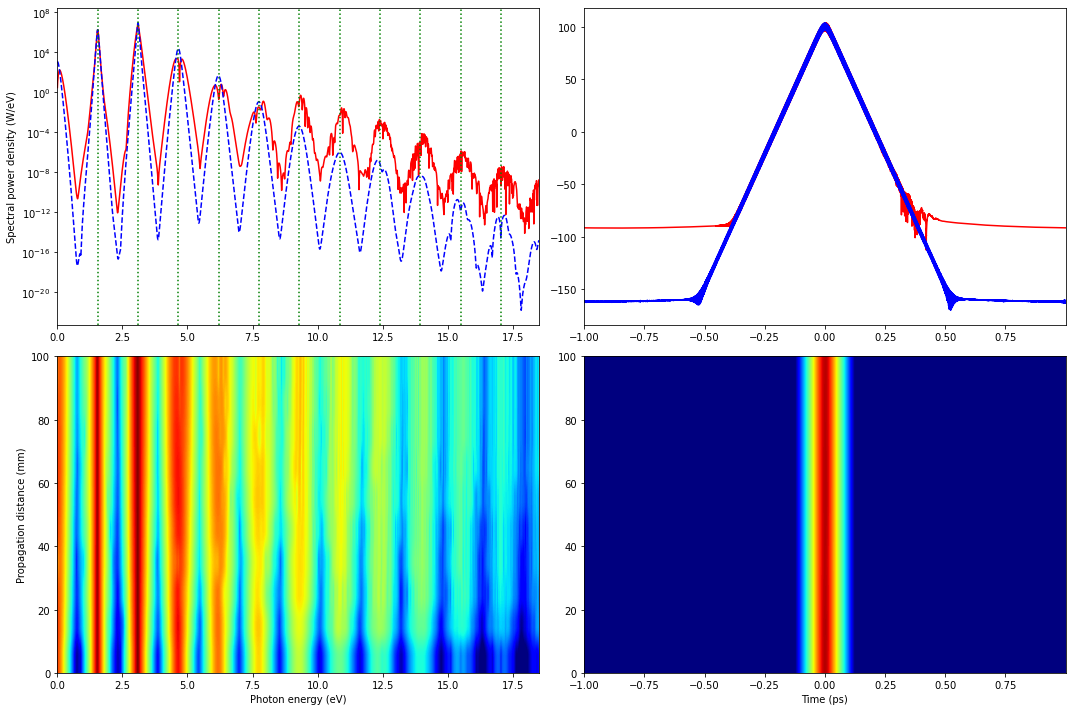

Pulse energy before Simple Fiber : 764537.9881776121 nJ
pulse energy in  63004980.894440554
copied as   63004980.894440554
Step: 0 Distance remaining: 0.1
Pulse energy after: 760207.2669835254 nJ
Step: 1 Distance remaining: 0.09000000000000001
Pulse energy after: 760289.0844599986 nJ
Step: 2 Distance remaining: 0.08000000000000002
Pulse energy after: 759540.8303797161 nJ
Step: 3 Distance remaining: 0.06999999999999999
Pulse energy after: 759070.4054830811 nJ
Step: 4 Distance remaining: 0.06
Pulse energy after: 759250.4666266735 nJ
Step: 5 Distance remaining: 0.05
Pulse energy after: 759510.3758028958 nJ
Step: 6 Distance remaining: 0.04000000000000001
Pulse energy after: 759454.0421260517 nJ
Step: 7 Distance remaining: 0.030000000000000006
Pulse energy after: 759163.9073042701 nJ
Step: 8 Distance remaining: 0.019999999999999997
Pulse energy after: 758866.8624352412 nJ
Step: 9 Distance remaining: 0.009999999999999998
Pulse energy after: 758682.5165461391 nJ
Pulse energy after Simple Fibe

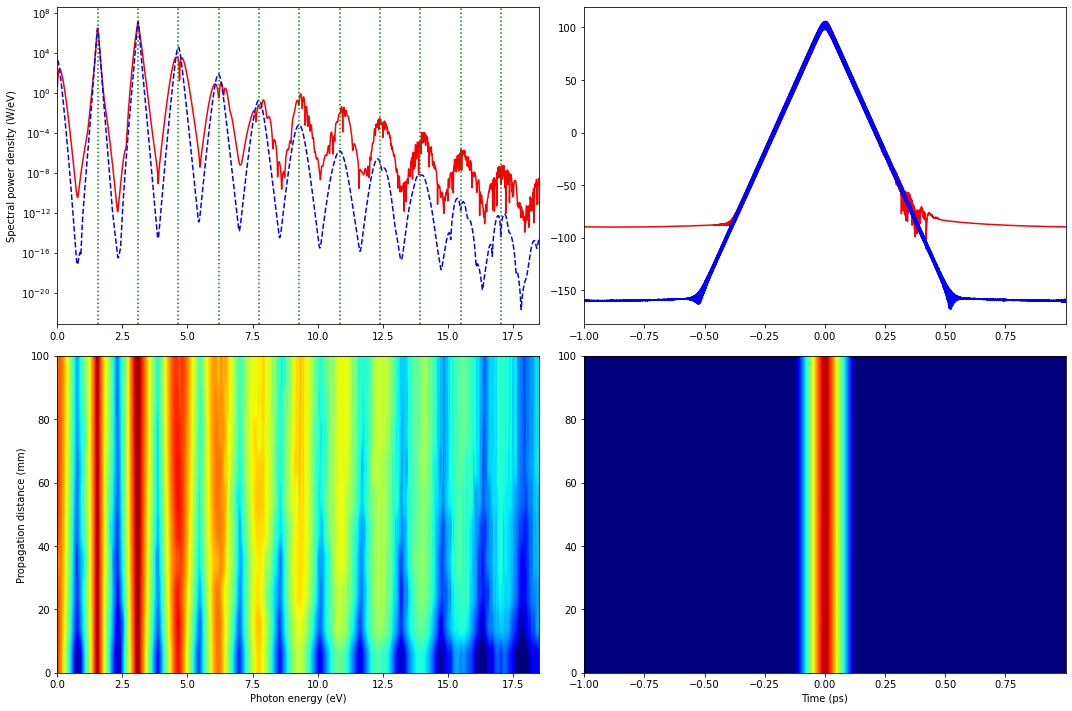

Pulse energy before Simple Fiber : 1130.9733552923253 nJ
pulse energy in  2423268.4959400212
copied as   2423268.4959400212
Step: 0 Distance remaining: 0.1
Pulse energy after: 1123.9658872359494 nJ
Step: 1 Distance remaining: 0.09000000000000001
Pulse energy after: 1123.981288371122 nJ
Step: 2 Distance remaining: 0.08000000000000002
Pulse energy after: 1124.0063533879081 nJ
Step: 3 Distance remaining: 0.06999999999999999
Pulse energy after: 1124.0364879764309 nJ
Step: 4 Distance remaining: 0.06
Pulse energy after: 1124.0685247406952 nJ
Step: 5 Distance remaining: 0.05
Pulse energy after: 1124.1006348320998 nJ
Step: 6 Distance remaining: 0.04000000000000001
Pulse energy after: 1124.1317381043266 nJ
Step: 7 Distance remaining: 0.030000000000000006
Pulse energy after: 1124.1607137842045 nJ
Step: 8 Distance remaining: 0.019999999999999997
Pulse energy after: 1124.1858927279675 nJ
Step: 9 Distance remaining: 0.009999999999999998
Pulse energy after: 1124.2045434091965 nJ
Pulse energy after S

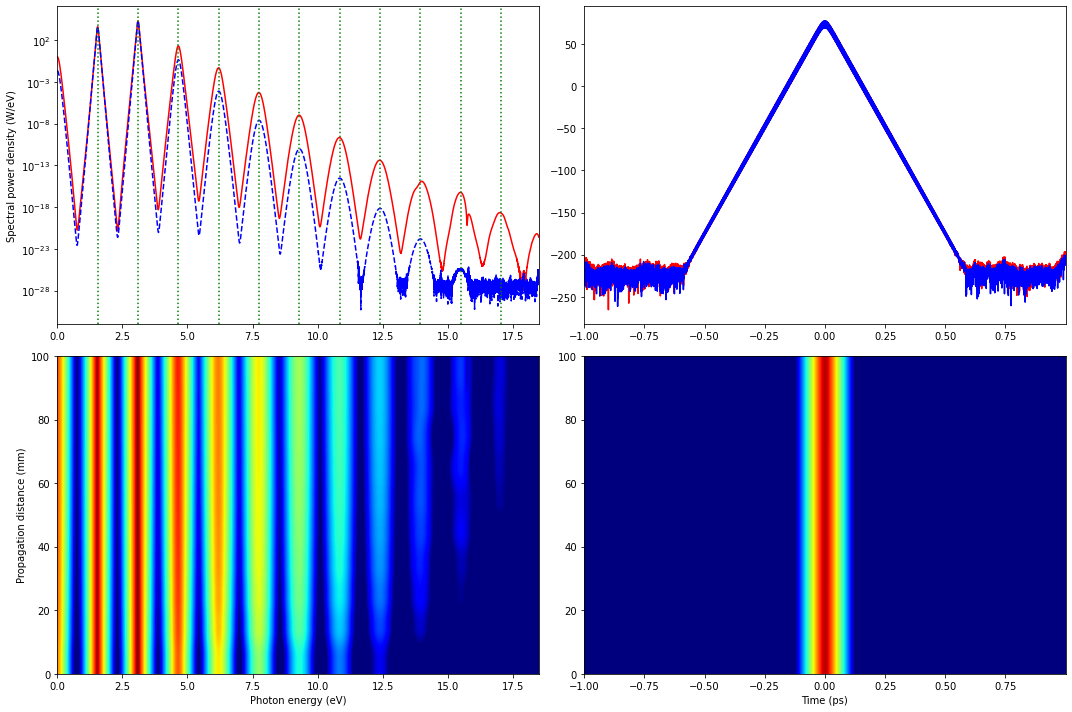

Pulse energy before Simple Fiber : 40715.04079052371 nJ
pulse energy in  14539610.975640126
copied as   14539610.975640126
Step: 0 Distance remaining: 0.1
Pulse energy after: 40462.7719404942 nJ
Step: 1 Distance remaining: 0.09000000000000001
Pulse energy after: 40463.32638136041 nJ
Step: 2 Distance remaining: 0.08000000000000002
Pulse energy after: 40464.22872196472 nJ
Step: 3 Distance remaining: 0.06999999999999999
Pulse energy after: 40465.313567151534 nJ
Step: 4 Distance remaining: 0.06
Pulse energy after: 40466.466890665055 nJ
Step: 5 Distance remaining: 0.05
Pulse energy after: 40467.62285395566 nJ
Step: 6 Distance remaining: 0.04000000000000001
Pulse energy after: 40468.742571755814 nJ
Step: 7 Distance remaining: 0.030000000000000006
Pulse energy after: 40469.78569623141 nJ
Step: 8 Distance remaining: 0.019999999999999997
Pulse energy after: 40470.6921382069 nJ
Step: 9 Distance remaining: 0.009999999999999998
Pulse energy after: 40471.36356273112 nJ
Pulse energy after Simple Fib

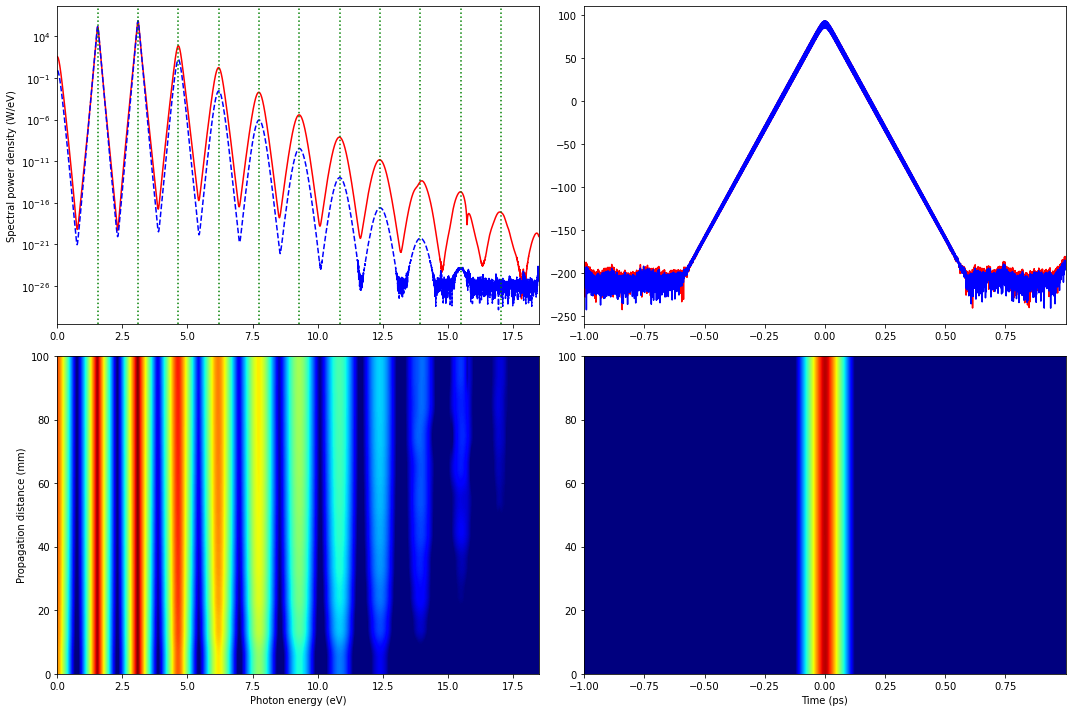

Pulse energy before Simple Fiber : 136847.77599037142 nJ
pulse energy in  26655953.45534023
copied as   26655953.45534023
Step: 0 Distance remaining: 0.1
Pulse energy after: 135999.87235555015 nJ
Step: 1 Distance remaining: 0.09000000000000001
Pulse energy after: 136001.73589290594 nJ
Step: 2 Distance remaining: 0.08000000000000002
Pulse energy after: 136004.76875993717 nJ
Step: 3 Distance remaining: 0.06999999999999999
Pulse energy after: 136008.41504514834 nJ
Step: 4 Distance remaining: 0.06
Pulse energy after: 136012.29149362436 nJ
Step: 5 Distance remaining: 0.05
Pulse energy after: 136016.1768146844 nJ
Step: 6 Distance remaining: 0.04000000000000001
Pulse energy after: 136019.94031062382 nJ
Step: 7 Distance remaining: 0.030000000000000006
Pulse energy after: 136023.4463678891 nJ
Step: 8 Distance remaining: 0.019999999999999997
Pulse energy after: 136026.49302008437 nJ
Step: 9 Distance remaining: 0.009999999999999998
Pulse energy after: 136028.7497525131 nJ
Pulse energy after Simpl

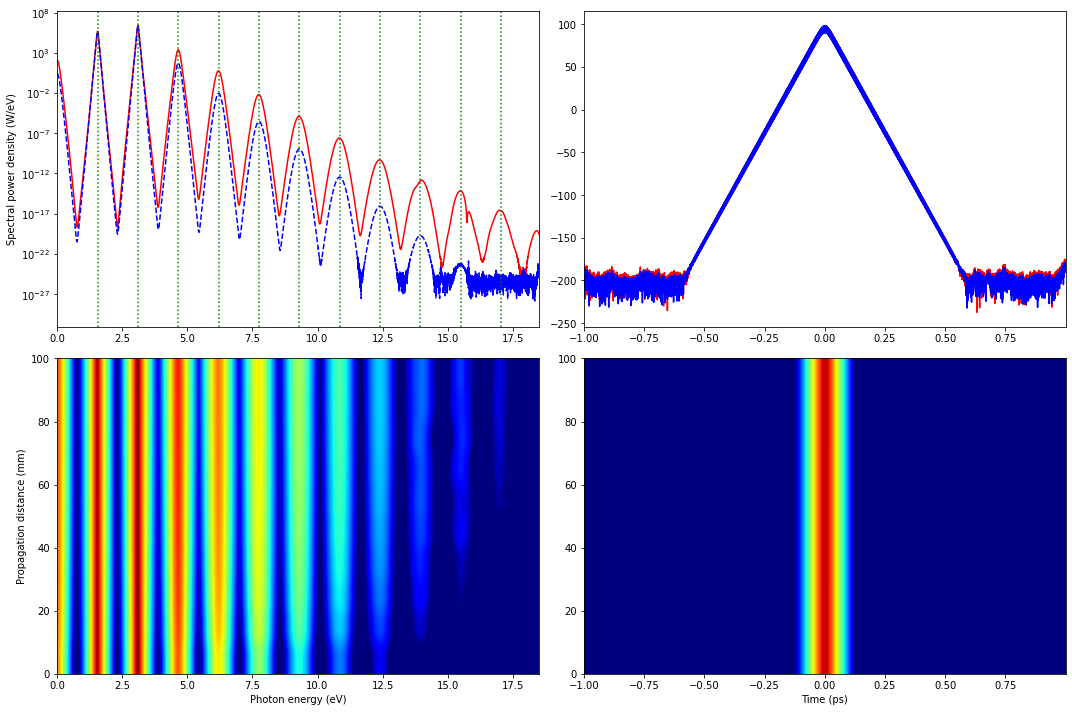

Pulse energy before Simple Fiber : 289529.1789548353 nJ
pulse energy in  38772295.93504034
copied as   38772295.93504034
Step: 0 Distance remaining: 0.1
Pulse energy after: 287735.26713240304 nJ
Step: 1 Distance remaining: 0.09000000000000001
Pulse energy after: 287739.20982300723 nJ
Step: 2 Distance remaining: 0.08000000000000002
Pulse energy after: 287745.6264673045 nJ
Step: 3 Distance remaining: 0.06999999999999999
Pulse energy after: 287753.3409219663 nJ
Step: 4 Distance remaining: 0.06
Pulse energy after: 287761.542333618 nJ
Step: 5 Distance remaining: 0.05
Pulse energy after: 287769.76251701755 nJ
Step: 6 Distance remaining: 0.04000000000000001
Pulse energy after: 287777.7249547076 nJ
Step: 7 Distance remaining: 0.030000000000000006
Pulse energy after: 287785.14272875636 nJ
Step: 8 Distance remaining: 0.019999999999999997
Pulse energy after: 287791.5885383597 nJ
Step: 9 Distance remaining: 0.009999999999999998
Pulse energy after: 287796.3631127543 nJ
Pulse energy after Simple Fib

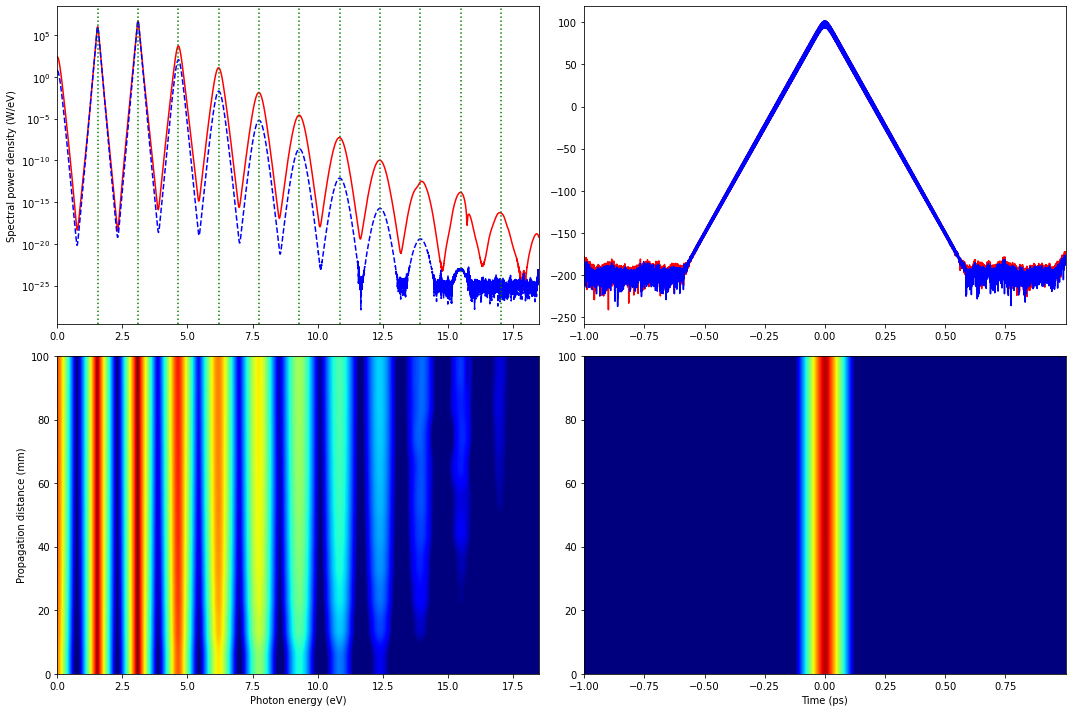

Pulse energy before Simple Fiber : 498759.24968391546 nJ
pulse energy in  50888638.41474044
copied as   50888638.41474044
Step: 0 Distance remaining: 0.1
Pulse energy after: 495668.9562710542 nJ
Step: 1 Distance remaining: 0.09000000000000001
Pulse energy after: 495675.7481716651 nJ
Step: 2 Distance remaining: 0.08000000000000002
Pulse energy after: 495686.8018440679 nJ
Step: 3 Distance remaining: 0.06999999999999999
Pulse energy after: 495700.0911976063 nJ
Step: 4 Distance remaining: 0.06
Pulse energy after: 495714.21941064706 nJ
Step: 5 Distance remaining: 0.05
Pulse energy after: 495728.37996095675 nJ
Step: 6 Distance remaining: 0.04000000000000001
Pulse energy after: 495742.09650400875 nJ
Step: 7 Distance remaining: 0.030000000000000006
Pulse energy after: 495754.87477883504 nJ
Step: 8 Distance remaining: 0.019999999999999997
Pulse energy after: 495765.9786930344 nJ
Step: 9 Distance remaining: 0.009999999999999998
Pulse energy after: 495774.20364345633 nJ
Pulse energy after Simple 

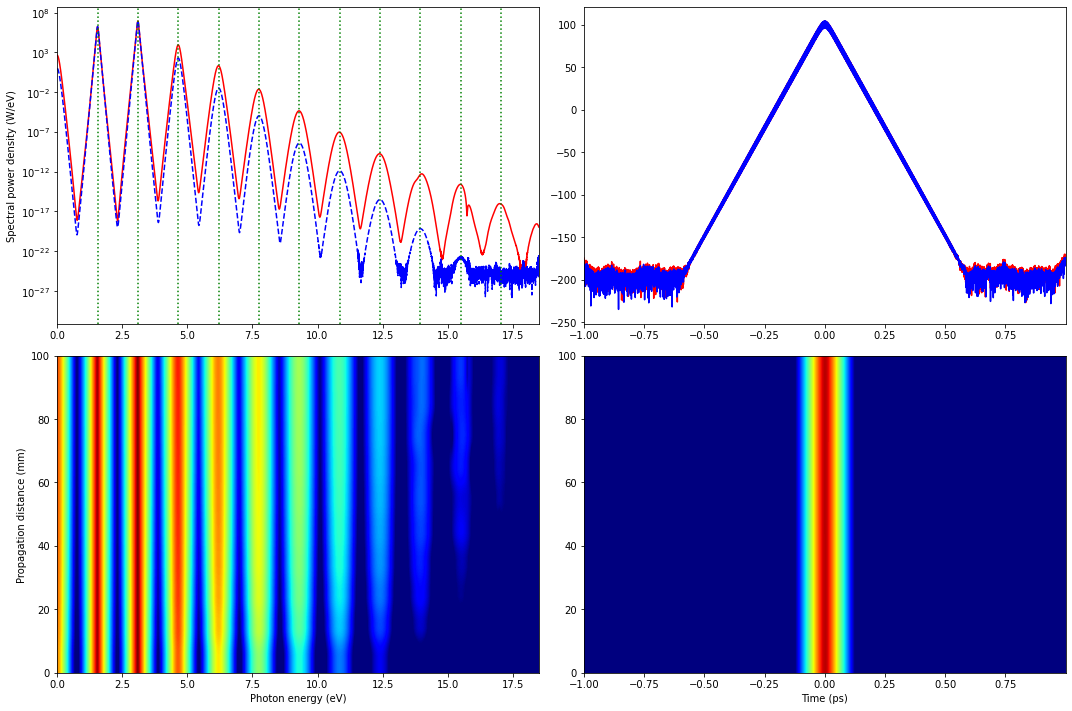

Pulse energy before Simple Fiber : 764537.9881776121 nJ
pulse energy in  63004980.894440554
copied as   63004980.894440554
Step: 0 Distance remaining: 0.1
Pulse energy after: 759800.9397715025 nJ
Step: 1 Distance remaining: 0.09000000000000001
Pulse energy after: 759811.3509388788 nJ
Step: 2 Distance remaining: 0.08000000000000002
Pulse energy after: 759828.2948902263 nJ
Step: 3 Distance remaining: 0.06999999999999999
Pulse energy after: 759848.6658720677 nJ
Step: 4 Distance remaining: 0.06
Pulse energy after: 759870.3227247106 nJ
Step: 5 Distance remaining: 0.05
Pulse energy after: 759892.0291465009 nJ
Step: 6 Distance remaining: 0.04000000000000001
Pulse energy after: 759913.0549585259 nJ
Step: 7 Distance remaining: 0.030000000000000006
Pulse energy after: 759932.6425181234 nJ
Step: 8 Distance remaining: 0.019999999999999997
Pulse energy after: 759949.6634841075 nJ
Step: 9 Distance remaining: 0.009999999999999998
Pulse energy after: 759962.2713446184 nJ
Pulse energy after Simple Fibe

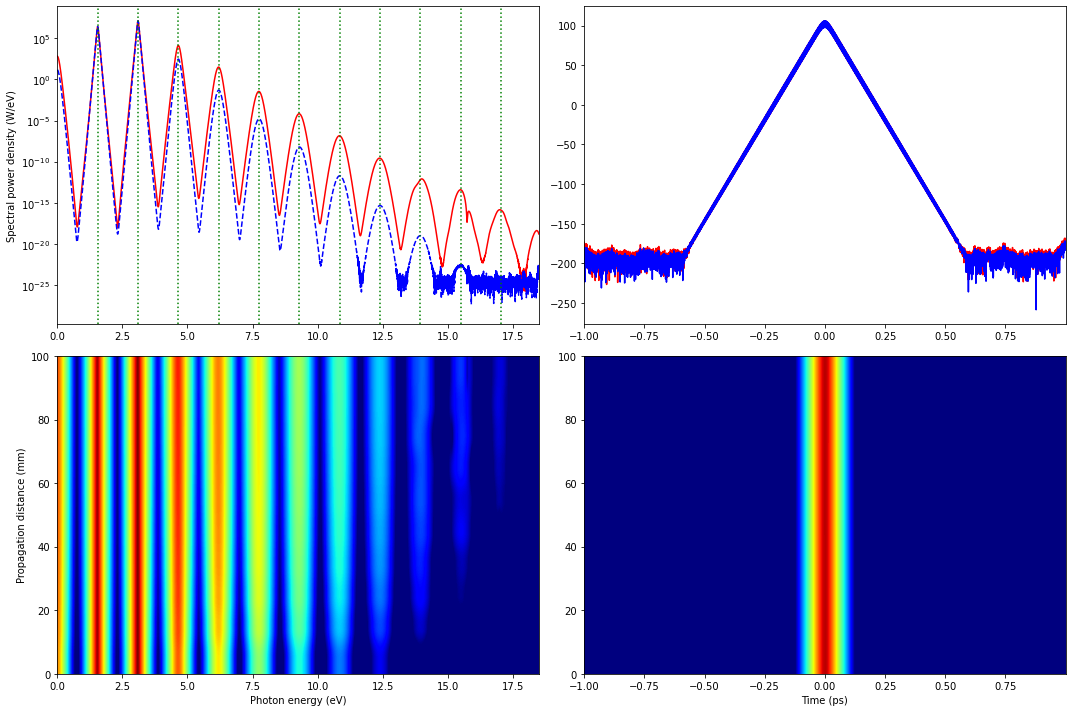

Pulse energy before Simple Fiber : 1130.9733552923253 nJ
pulse energy in  2423268.4959400212
copied as   2423268.4959400212
Step: 0 Distance remaining: 0.1
Pulse energy after: 1124.5750680333838 nJ
Step: 1 Distance remaining: 0.09000000000000001
Pulse energy after: 1122.934370654605 nJ
Step: 2 Distance remaining: 0.08000000000000002
Pulse energy after: 1123.1039383463756 nJ
Step: 3 Distance remaining: 0.06999999999999999
Pulse energy after: 1121.6958018680793 nJ
Step: 4 Distance remaining: 0.06
Pulse energy after: 1122.0275308992786 nJ
Step: 5 Distance remaining: 0.05
Pulse energy after: 1121.218279944703 nJ
Step: 6 Distance remaining: 0.04000000000000001
Pulse energy after: 1120.565533756151 nJ
Step: 7 Distance remaining: 0.030000000000000006
Pulse energy after: 1120.560876053827 nJ
Step: 8 Distance remaining: 0.019999999999999997
Pulse energy after: 1120.4940493011013 nJ
Step: 9 Distance remaining: 0.009999999999999998
Pulse energy after: 1120.288146115735 nJ
Pulse energy after Simpl

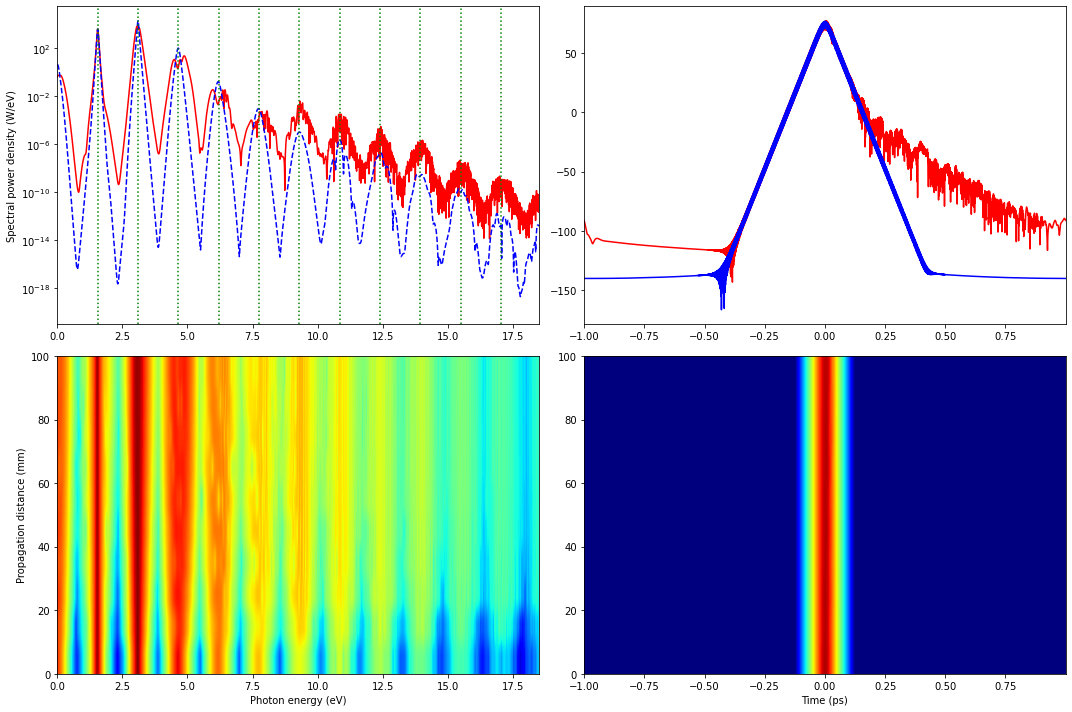

Pulse energy before Simple Fiber : 40715.04079052371 nJ
pulse energy in  14539610.975640126
copied as   14539610.975640126
Step: 0 Distance remaining: 0.1
Pulse energy after: 40484.702449201875 nJ
Step: 1 Distance remaining: 0.09000000000000001
Pulse energy after: 40425.63734356582 nJ
Step: 2 Distance remaining: 0.08000000000000002
Pulse energy after: 40431.741780469565 nJ
Step: 3 Distance remaining: 0.06999999999999999
Pulse energy after: 40381.0488672509 nJ
Step: 4 Distance remaining: 0.06
Pulse energy after: 40392.99111237408 nJ
Step: 5 Distance remaining: 0.05
Pulse energy after: 40363.85807800937 nJ
Step: 6 Distance remaining: 0.04000000000000001
Pulse energy after: 40340.3592152215 nJ
Step: 7 Distance remaining: 0.030000000000000006
Pulse energy after: 40340.19153793784 nJ
Step: 8 Distance remaining: 0.019999999999999997
Pulse energy after: 40337.7857748397 nJ
Step: 9 Distance remaining: 0.009999999999999998
Pulse energy after: 40330.373260166496 nJ
Pulse energy after Simple Fibe

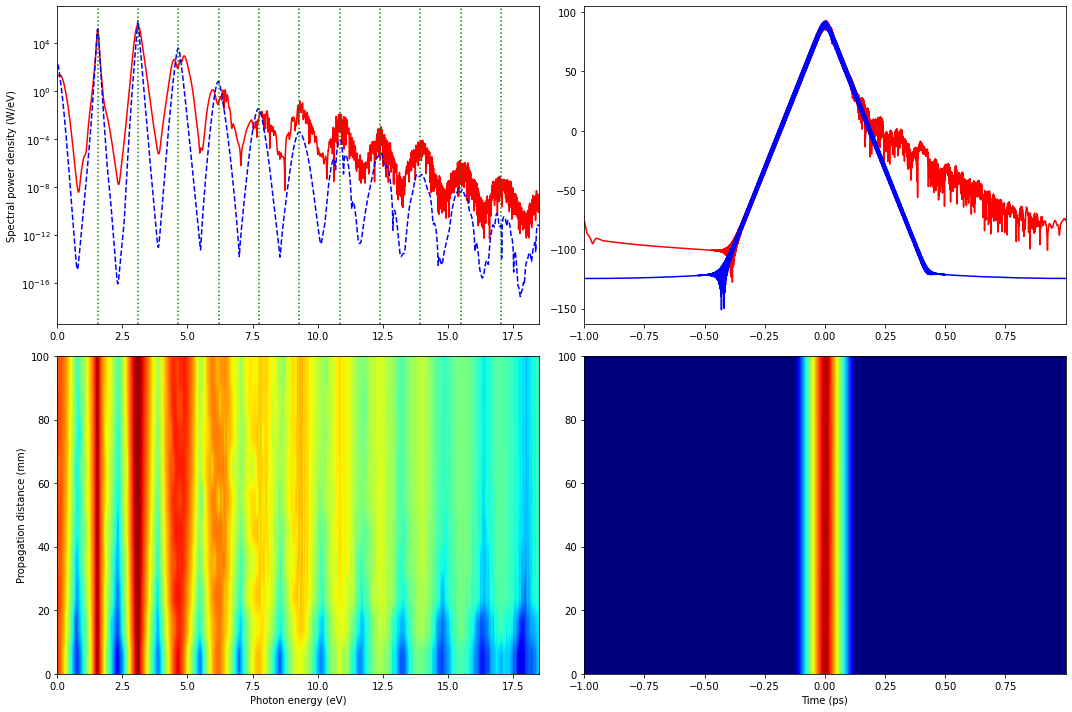

Pulse energy before Simple Fiber : 136847.77599037142 nJ
pulse energy in  26655953.45534023
copied as   26655953.45534023
Step: 0 Distance remaining: 0.1
Pulse energy after: 136073.58323203967 nJ
Step: 1 Distance remaining: 0.09000000000000001
Pulse energy after: 135875.0588492073 nJ
Step: 2 Distance remaining: 0.08000000000000002
Pulse energy after: 135895.5765399116 nJ
Step: 3 Distance remaining: 0.06999999999999999
Pulse energy after: 135725.1920260377 nJ
Step: 4 Distance remaining: 0.06
Pulse energy after: 135765.33123881283 nJ
Step: 5 Distance remaining: 0.05
Pulse energy after: 135667.41187330917 nJ
Step: 6 Distance remaining: 0.04000000000000001
Pulse energy after: 135588.42958449436 nJ
Step: 7 Distance remaining: 0.030000000000000006
Pulse energy after: 135587.86600251315 nJ
Step: 8 Distance remaining: 0.019999999999999997
Pulse energy after: 135579.77996543332 nJ
Step: 9 Distance remaining: 0.009999999999999998
Pulse energy after: 135554.86568000395 nJ
Pulse energy after Simpl

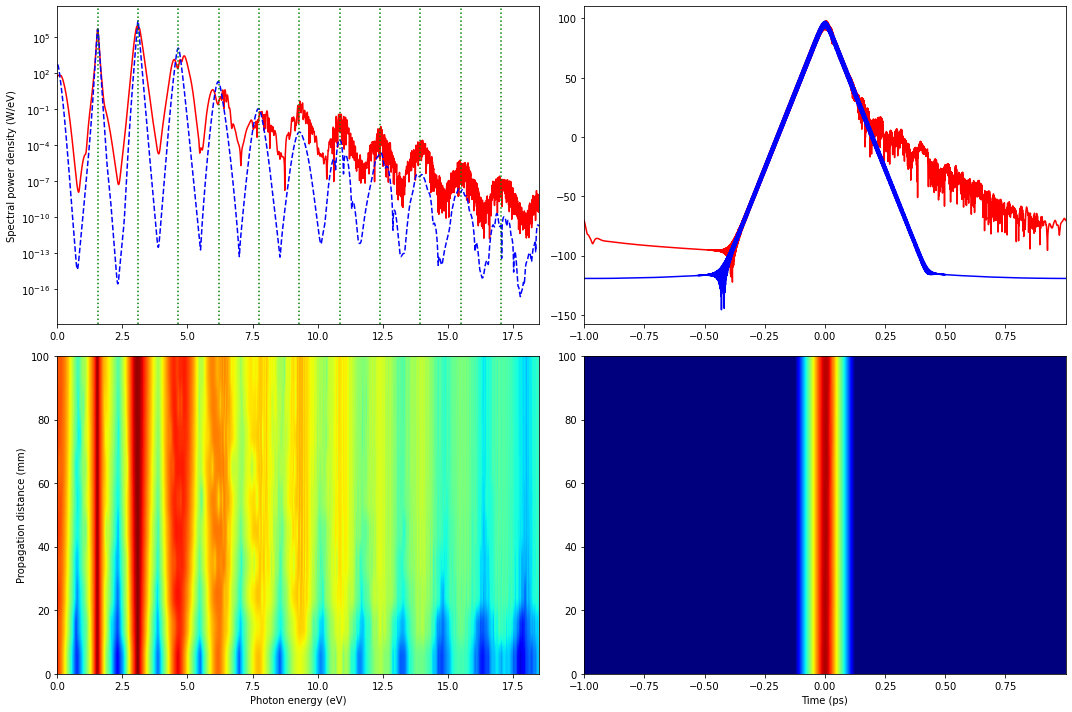

Pulse energy before Simple Fiber : 289529.1789548353 nJ
pulse energy in  38772295.93504034
copied as   38772295.93504034
Step: 0 Distance remaining: 0.1
Pulse energy after: 287891.21741654625 nJ
Step: 1 Distance remaining: 0.09000000000000001
Pulse energy after: 287471.19888757885 nJ
Step: 2 Distance remaining: 0.08000000000000002
Pulse energy after: 287514.60821667215 nJ
Step: 3 Distance remaining: 0.06999999999999999
Pulse energy after: 287154.1252782283 nJ
Step: 4 Distance remaining: 0.06
Pulse energy after: 287239.04791021533 nJ
Step: 5 Distance remaining: 0.05
Pulse energy after: 287031.87966584397 nJ
Step: 6 Distance remaining: 0.04000000000000001
Pulse energy after: 286864.77664157463 nJ
Step: 7 Distance remaining: 0.030000000000000006
Pulse energy after: 286863.58426977973 nJ
Step: 8 Distance remaining: 0.019999999999999997
Pulse energy after: 286846.47662108194 nJ
Step: 9 Distance remaining: 0.009999999999999998
Pulse energy after: 286793.76540562813 nJ
Pulse energy after Simp

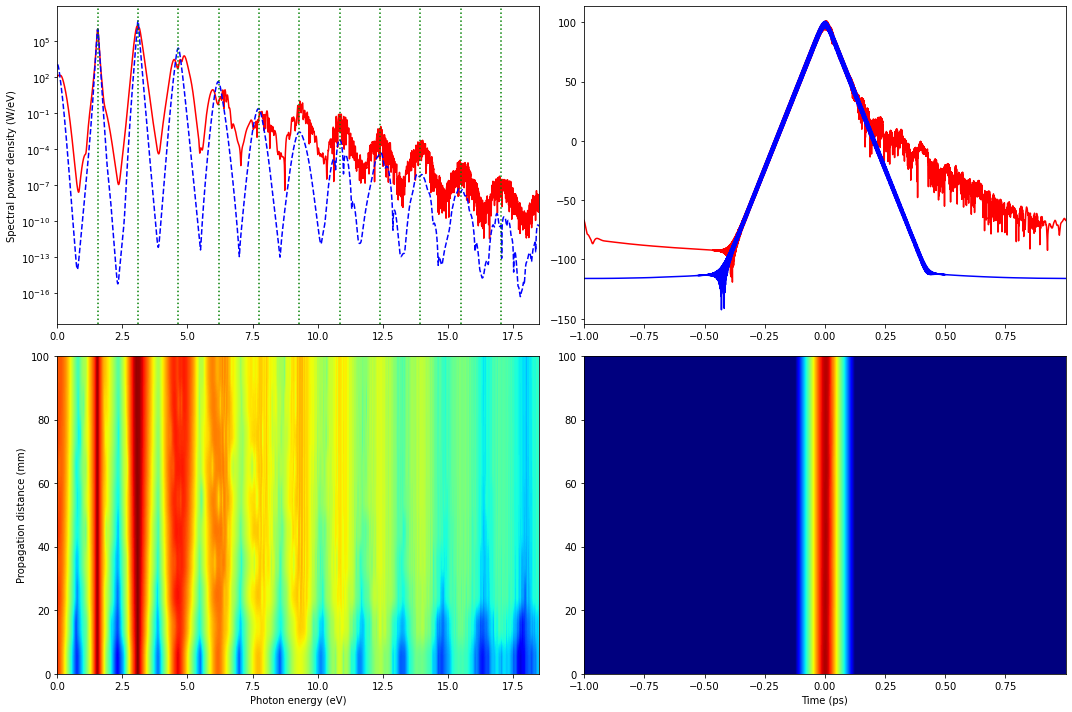

Pulse energy before Simple Fiber : 498759.24968391546 nJ
pulse energy in  50888638.41474044
copied as   50888638.41474044
Step: 0 Distance remaining: 0.1
Pulse energy after: 495937.60500272294 nJ
Step: 1 Distance remaining: 0.09000000000000001
Pulse energy after: 495214.0574586813 nJ
Step: 2 Distance remaining: 0.08000000000000002
Pulse energy after: 495288.83681075205 nJ
Step: 3 Distance remaining: 0.06999999999999999
Pulse energy after: 494667.84862382343 nJ
Step: 4 Distance remaining: 0.06
Pulse energy after: 494814.14112658263 nJ
Step: 5 Distance remaining: 0.05
Pulse energy after: 494457.26145561464 nJ
Step: 6 Distance remaining: 0.04000000000000001
Pulse energy after: 494169.40038646327 nJ
Step: 7 Distance remaining: 0.030000000000000006
Pulse energy after: 494167.34633973835 nJ
Step: 8 Distance remaining: 0.019999999999999997
Pulse energy after: 494137.87574178615 nJ
Step: 9 Distance remaining: 0.009999999999999998
Pulse energy after: 494047.0724370395 nJ
Pulse energy after Simp

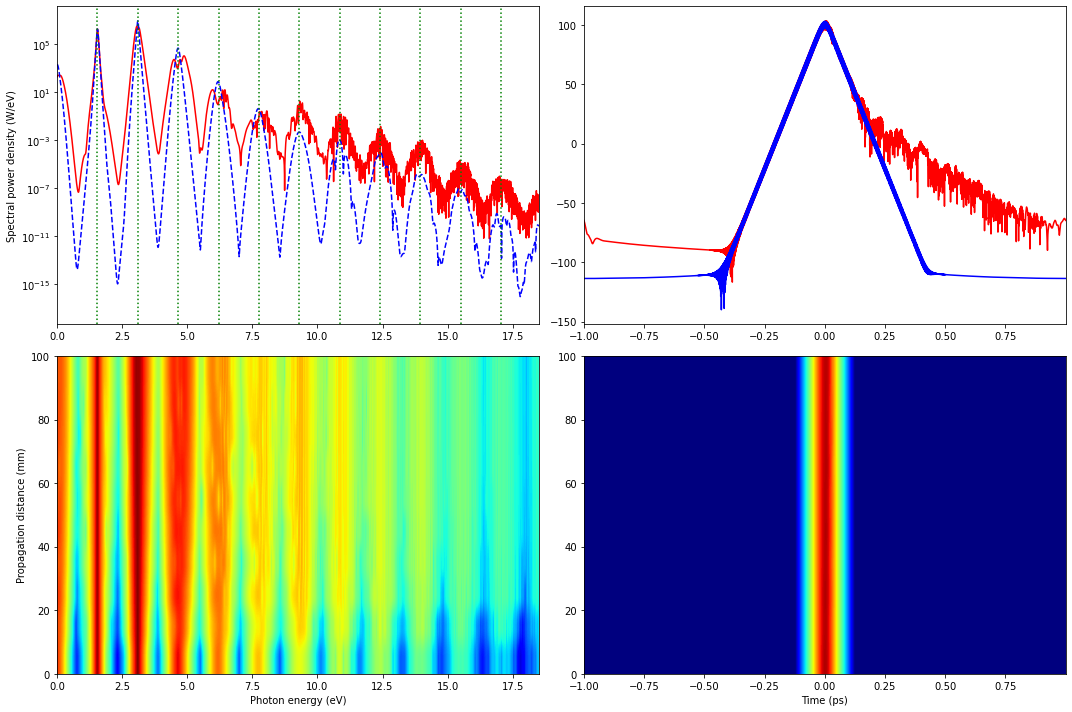

Pulse energy before Simple Fiber : 764537.9881776121 nJ
pulse energy in  63004980.894440554
copied as   63004980.894440554
Step: 0 Distance remaining: 0.1
Pulse energy after: 760212.7459905682 nJ
Step: 1 Distance remaining: 0.09000000000000001
Pulse energy after: 759103.6345625134 nJ
Step: 2 Distance remaining: 0.08000000000000002
Pulse energy after: 759218.2623221504 nJ
Step: 3 Distance remaining: 0.06999999999999999
Pulse energy after: 758266.3620628221 nJ
Step: 4 Distance remaining: 0.06
Pulse energy after: 758490.6108879131 nJ
Step: 5 Distance remaining: 0.05
Pulse energy after: 757943.5572426197 nJ
Step: 6 Distance remaining: 0.04000000000000001
Pulse energy after: 757502.3008191583 nJ
Step: 7 Distance remaining: 0.030000000000000006
Pulse energy after: 757499.1522123873 nJ
Step: 8 Distance remaining: 0.019999999999999997
Pulse energy after: 757453.9773275445 nJ
Step: 9 Distance remaining: 0.009999999999999998
Pulse energy after: 757314.7867742369 nJ
Pulse energy after Simple Fibe

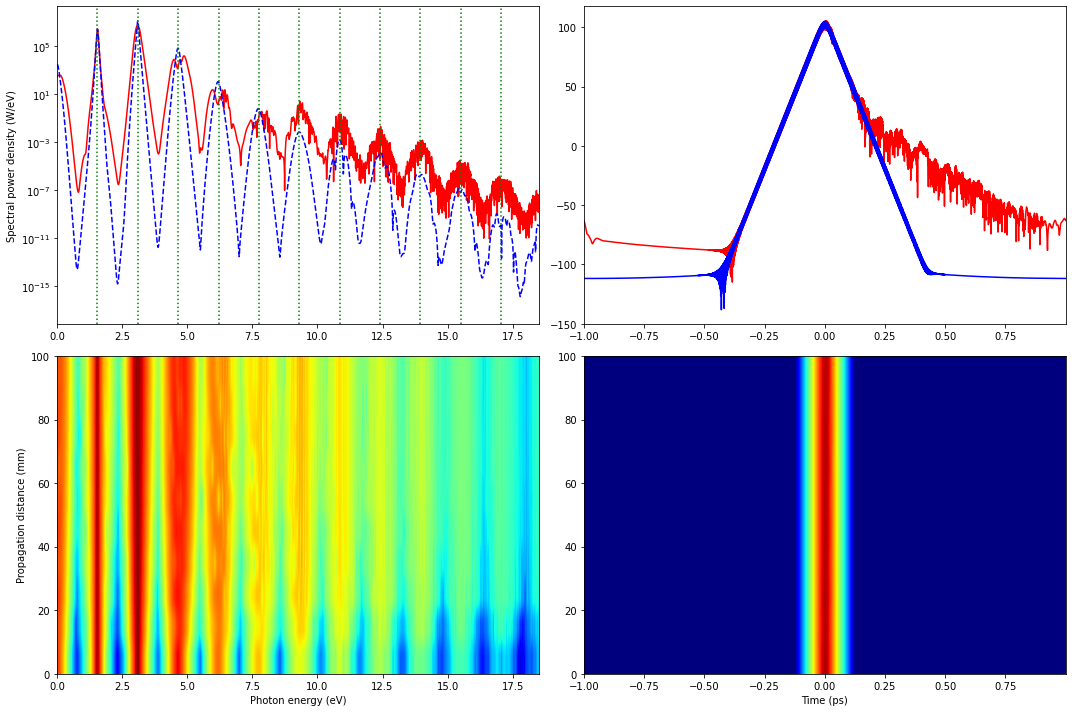

Pulse energy before Simple Fiber : 1130.9733552923253 nJ
pulse energy in  2423268.4959400212
copied as   2423268.4959400212
Step: 0 Distance remaining: 0.1
Pulse energy after: 1123.5617376826751 nJ
Step: 1 Distance remaining: 0.09000000000000001
Pulse energy after: 1121.4358316335786 nJ
Step: 2 Distance remaining: 0.08000000000000002
Pulse energy after: 1119.8418256130535 nJ
Step: 3 Distance remaining: 0.06999999999999999
Pulse energy after: 1118.4206682600507 nJ
Step: 4 Distance remaining: 0.06
Pulse energy after: 1117.0202845951005 nJ
Step: 5 Distance remaining: 0.05
Pulse energy after: 1115.935399988233 nJ
Step: 6 Distance remaining: 0.04000000000000001
Pulse energy after: 1114.9994470453908 nJ
Step: 7 Distance remaining: 0.030000000000000006
Pulse energy after: 1114.1928068733262 nJ
Step: 8 Distance remaining: 0.019999999999999997
Pulse energy after: 1113.5753646750081 nJ
Step: 9 Distance remaining: 0.009999999999999998
Pulse energy after: 1113.1626993286816 nJ
Pulse energy after S

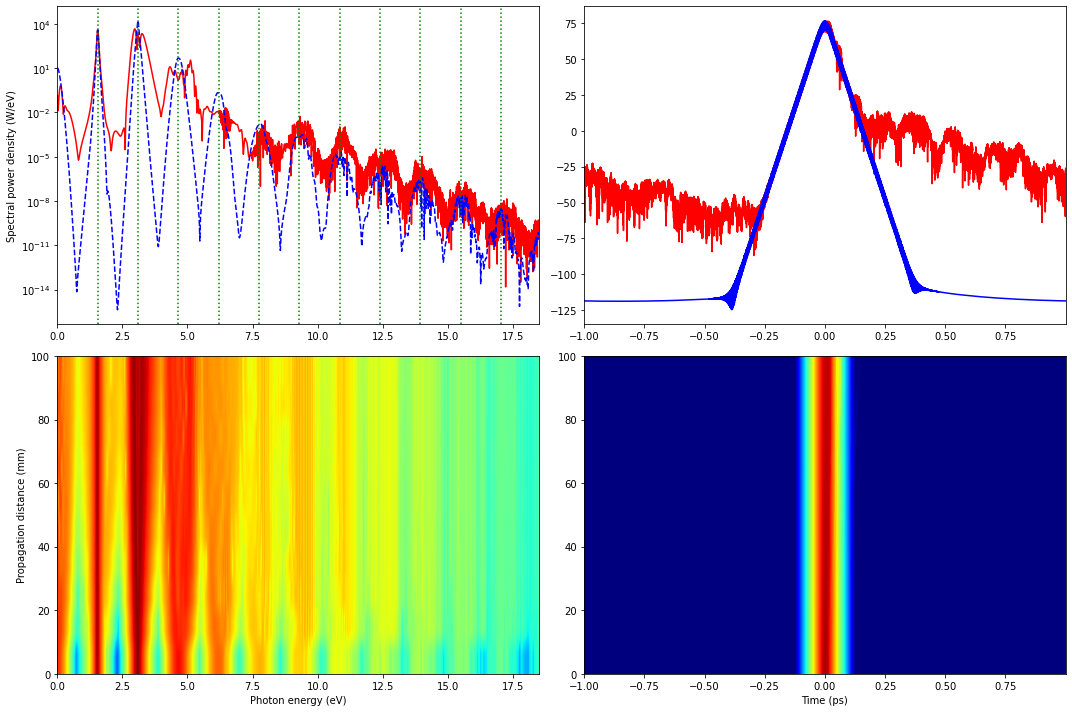

Pulse energy before Simple Fiber : 40715.04079052371 nJ
pulse energy in  14539610.975640126
copied as   14539610.975640126
Step: 0 Distance remaining: 0.1
Pulse energy after: 40448.22255657635 nJ
Step: 1 Distance remaining: 0.09000000000000001
Pulse energy after: 40371.68993880887 nJ
Step: 2 Distance remaining: 0.08000000000000002
Pulse energy after: 40314.30572206998 nJ
Step: 3 Distance remaining: 0.06999999999999999
Pulse energy after: 40263.14405736187 nJ
Step: 4 Distance remaining: 0.06
Pulse energy after: 40212.73024542366 nJ
Step: 5 Distance remaining: 0.05
Pulse energy after: 40173.67439957644 nJ
Step: 6 Distance remaining: 0.04000000000000001
Pulse energy after: 40139.98009363412 nJ
Step: 7 Distance remaining: 0.030000000000000006
Pulse energy after: 40110.9410474398 nJ
Step: 8 Distance remaining: 0.019999999999999997
Pulse energy after: 40088.713128300355 nJ
Step: 9 Distance remaining: 0.009999999999999998
Pulse energy after: 40073.85717583258 nJ
Pulse energy after Simple Fibe

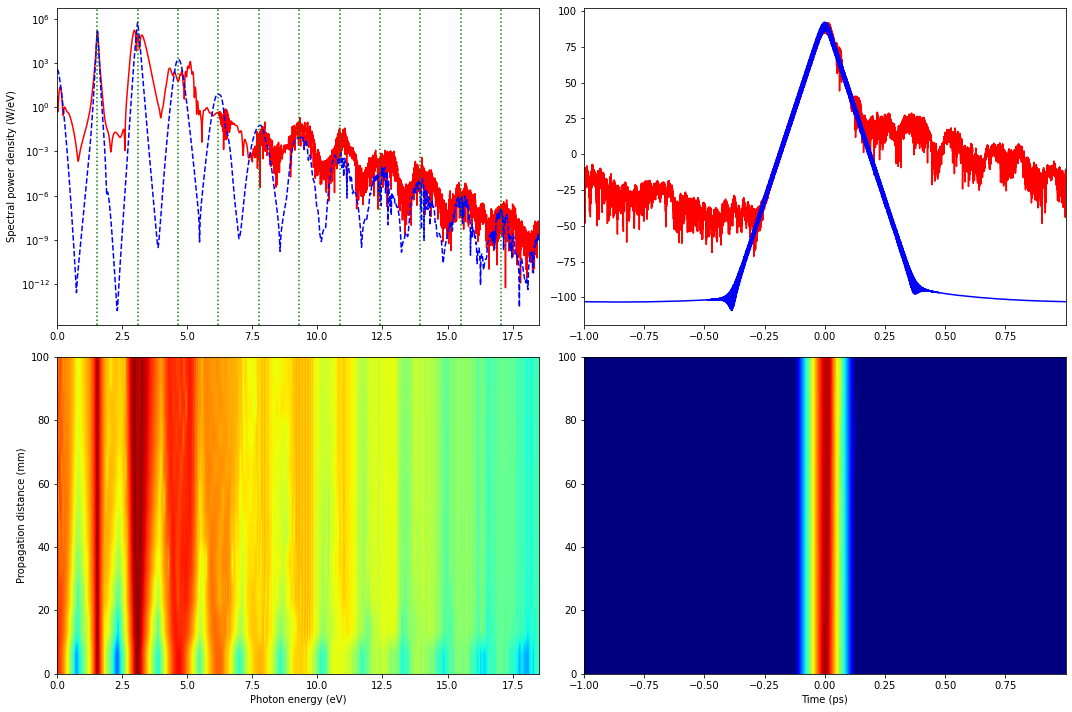

Pulse energy before Simple Fiber : 136847.77599037142 nJ
pulse energy in  26655953.45534023
copied as   26655953.45534023
Step: 0 Distance remaining: 0.1
Pulse energy after: 135950.97025960384 nJ
Step: 1 Distance remaining: 0.09000000000000001
Pulse energy after: 135693.73562766318 nJ
Step: 2 Distance remaining: 0.08000000000000002
Pulse energy after: 135500.86089917962 nJ
Step: 3 Distance remaining: 0.06999999999999999
Pulse energy after: 135328.9008594663 nJ
Step: 4 Distance remaining: 0.06
Pulse energy after: 135159.4544360073 nJ
Step: 5 Distance remaining: 0.05
Pulse energy after: 135028.18339857637 nJ
Step: 6 Distance remaining: 0.04000000000000001
Pulse energy after: 134914.93309249246 nJ
Step: 7 Distance remaining: 0.030000000000000006
Pulse energy after: 134817.32963167265 nJ
Step: 8 Distance remaining: 0.019999999999999997
Pulse energy after: 134742.61912567622 nJ
Step: 9 Distance remaining: 0.009999999999999998
Pulse energy after: 134692.68661877065 nJ
Pulse energy after Simp

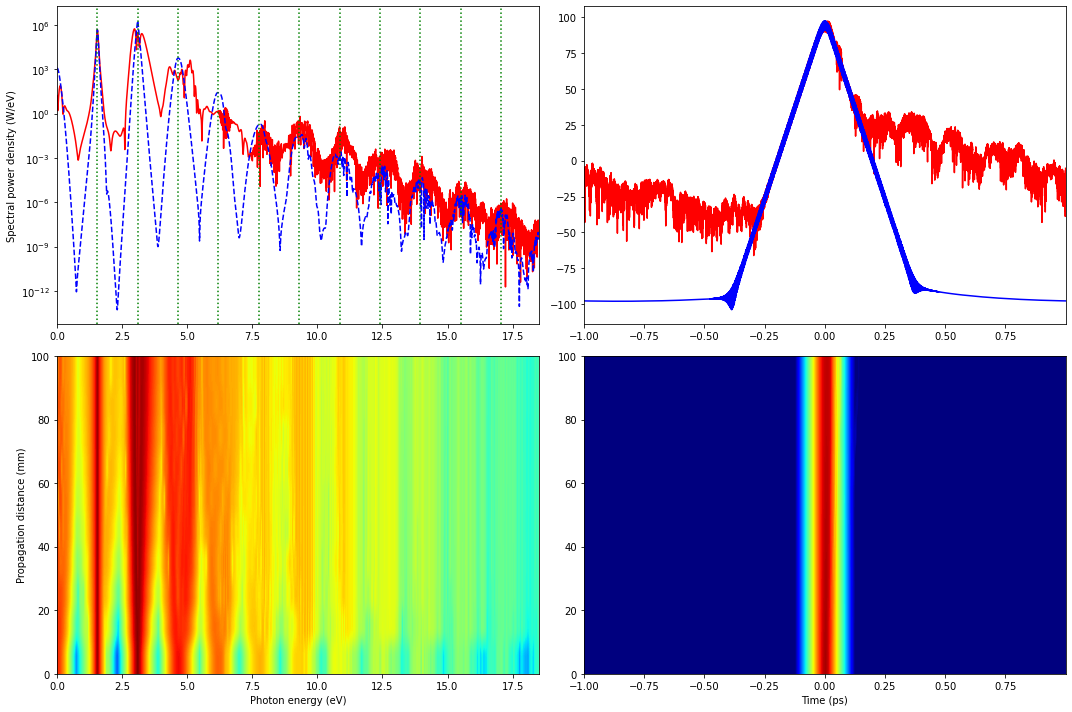

Pulse energy before Simple Fiber : 289529.1789548353 nJ
pulse energy in  38772295.93504034
copied as   38772295.93504034
Step: 0 Distance remaining: 0.1
Pulse energy after: 287631.80484676483 nJ
Step: 1 Distance remaining: 0.09000000000000001
Pulse energy after: 287087.5728981961 nJ
Step: 2 Distance remaining: 0.08000000000000002
Pulse energy after: 286679.5073569417 nJ
Step: 3 Distance remaining: 0.06999999999999999
Pulse energy after: 286315.69107457297 nJ
Step: 4 Distance remaining: 0.06
Pulse energy after: 285957.19285634573 nJ
Step: 5 Distance remaining: 0.05
Pulse energy after: 285679.46239698766 nJ
Step: 6 Distance remaining: 0.04000000000000001
Pulse energy after: 285439.85844362003 nJ
Step: 7 Distance remaining: 0.030000000000000006
Pulse energy after: 285233.3585595715 nJ
Step: 8 Distance remaining: 0.019999999999999997
Pulse energy after: 285075.2933568021 nJ
Step: 9 Distance remaining: 0.009999999999999998
Pulse energy after: 284969.6510281425 nJ
Pulse energy after Simple F

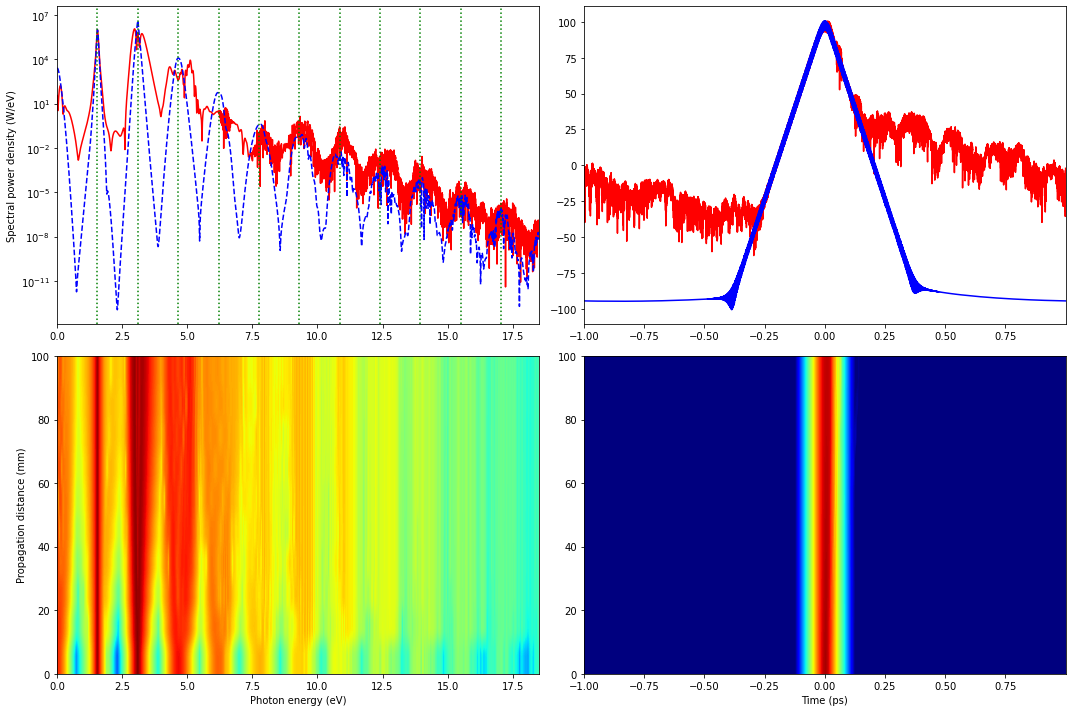

Pulse energy before Simple Fiber : 498759.24968391546 nJ
pulse energy in  50888638.41474044
copied as   50888638.41474044
Step: 0 Distance remaining: 0.1
Pulse energy after: 495490.7263180597 nJ
Step: 1 Distance remaining: 0.09000000000000001
Pulse energy after: 494553.2017504083 nJ
Step: 2 Distance remaining: 0.08000000000000002
Pulse energy after: 493850.24509535666 nJ
Step: 3 Distance remaining: 0.06999999999999999
Pulse energy after: 493223.51470268227 nJ
Step: 4 Distance remaining: 0.06
Pulse energy after: 492605.9455064392 nJ
Step: 5 Distance remaining: 0.05
Pulse energy after: 492127.5113948106 nJ
Step: 6 Distance remaining: 0.04000000000000001
Pulse energy after: 491714.75614701724 nJ
Step: 7 Distance remaining: 0.030000000000000006
Pulse energy after: 491359.0278311367 nJ
Step: 8 Distance remaining: 0.019999999999999997
Pulse energy after: 491086.7358216786 nJ
Step: 9 Distance remaining: 0.009999999999999998
Pulse energy after: 490904.7504039484 nJ
Pulse energy after Simple Fi

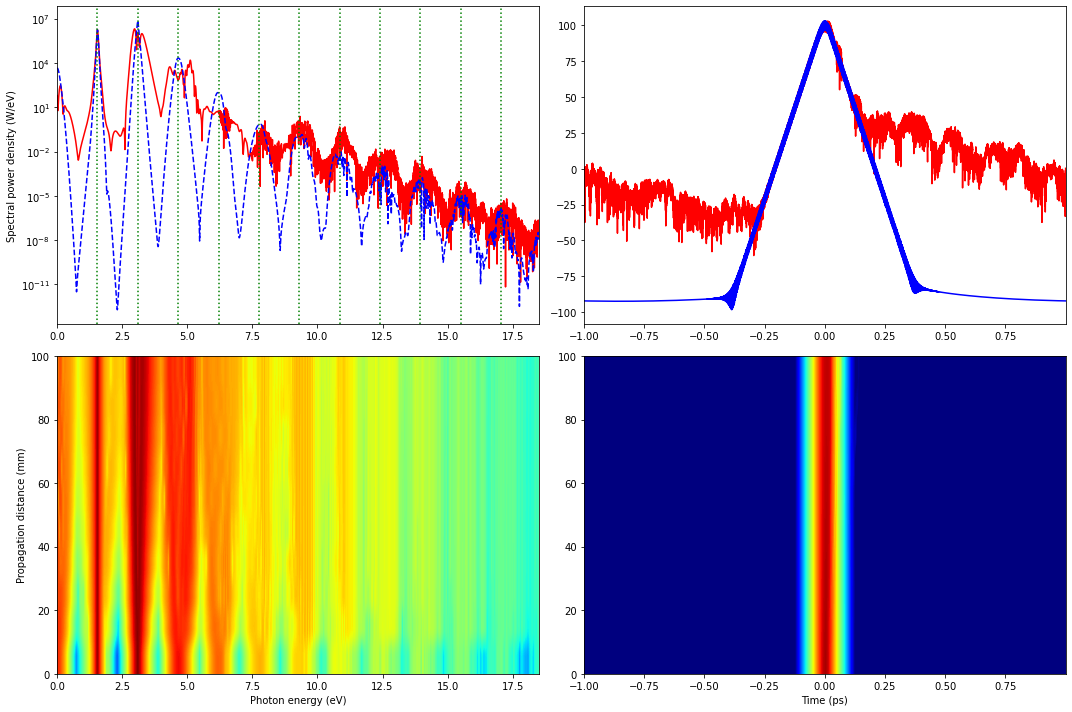

Pulse energy before Simple Fiber : 764537.9881776121 nJ
pulse energy in  63004980.894440554
copied as   63004980.894440554
Step: 0 Distance remaining: 0.1
Pulse energy after: 759527.7346734895 nJ
Step: 1 Distance remaining: 0.09000000000000001
Pulse energy after: 758090.6221843002 nJ
Step: 2 Distance remaining: 0.08000000000000002
Pulse energy after: 757013.0741144251 nJ
Step: 3 Distance remaining: 0.06999999999999999
Pulse energy after: 756052.3717437951 nJ
Step: 4 Distance remaining: 0.06
Pulse energy after: 755105.7123862886 nJ
Step: 5 Distance remaining: 0.05
Pulse energy after: 754372.3303920464 nJ
Step: 6 Distance remaining: 0.04000000000000001
Pulse energy after: 753739.6262026851 nJ
Step: 7 Distance remaining: 0.030000000000000006
Pulse energy after: 753194.3374463697 nJ
Step: 8 Distance remaining: 0.019999999999999997
Pulse energy after: 752776.9465203069 nJ
Step: 9 Distance remaining: 0.009999999999999998
Pulse energy after: 752497.9847461898 nJ
Pulse energy after Simple Fibe

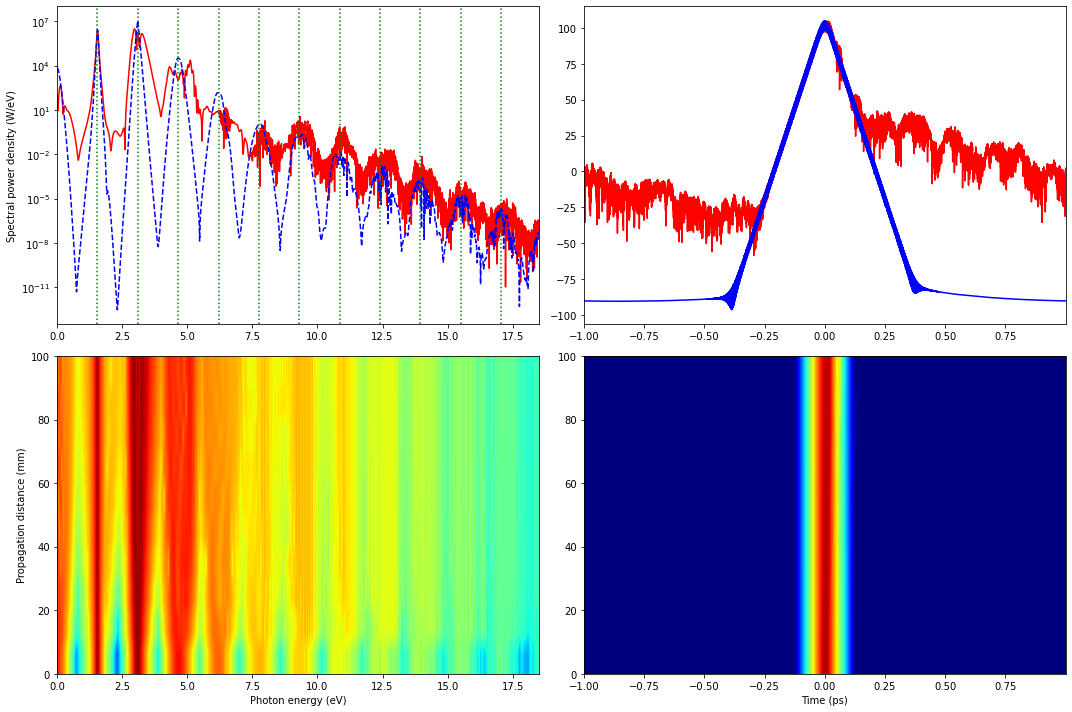

In [122]:
gases = ["Argon", "Neon", "Krypton", "Xenon"]

for gas in gases:
    n2_at_one_bar, betas_at_one_bar = loadGasParameters(gas)
    for i in range(len(fiber_rad)):
        gasbuilder = GasPropertyBuilder(fiber_length=Length*1e-3, 
                                        fiber_radius=fiber_rad[i], 
                                        fiber_wavelength=fibWL, 
                                        pulse_wavelength=pulseWL, 
                                        betas_at_one_bar=betas_at_one_bar, 
                                        constant_pressure=None, 
                                        pressure_boundary=[1000,0], 
                                        n2_at_one_bar=n2_at_one_bar, 
                                        differential_pumping=True)

        # create the fiber
        fiber = pynlo.media.fibers.fiber.FiberInstance()
        fiber.generate_fiber(Length * 1e-3, center_wl_nm=fibWL, betas=gasbuilder.dispersionFunction(0),
                                  gamma_W_m=gasbuilder.gammaDistribution(0), gain=-alpha)

        # provide a function for gamma (the effective nonlinearity, in units of 1/(W m)) that varies
        # as a function of the length along the fiber
        fiber.set_gamma_function(gasbuilder.gammaDistribution)

        # provide a function for the fiber dispersion that varies as a function of the length along
        # the fiber, GVD in units of ps^n/m, NOT ps^n/km
        fiber.set_dispersion_function(gasbuilder.dispersionFunction, dispersion_format='GVD')


        # create the fundamental pulse
        pulse_FD = pynlo.light.DerivedPulses.SechPulse(
            1, FWHM/1.76, pulseWL, time_window_ps=Window,
            GDD=GDD, TOD=TOD, NPTS=Points, frep_MHz=1e-3, power_is_avg=True
        )
        pulse_FD.set_epp(EPP_FD[i])

        # create the second harmonic pulse
        pulse_SH = pulse_FD.interpolate_to_new_center_wl(pulseWL/2)
        pulse_SH.set_epp(EPP_SH[i])

        # create the combined pulse
        pulse = pynlo.light.PulseBase.Pulse()
        pulse.set_NPTS(Points)
        pulse.set_time_window_ps(Window)
        pulse.set_center_wavelength_nm(fibWL)
        pulse.set_AW(pulse_FD.AW + pulse_SH.AW)

        # propagation
        evol = pynlo.interactions.FourWaveMixing.SSFM.SSFM(local_error=0.001, USE_SIMPLE_RAMAN=True,
                         disable_Raman=np.logical_not(Raman),
                         disable_self_steepening=np.logical_not(Steep))

        y, AW, AT, pulse_out = evol.propagate(pulse_in=pulse, fiber=fiber, n_steps=Steps, reload_fiber_each_step=True)

        print("The following results are for: ")
        print(f"\tGas: {gas}")
        print(f"\tFiber radius: {fiber_rad[i]*1e6:.4} microns")
        print(f"\tInput pulse energy: {total_EPP[i]*1e3:.4} mJ")

        # set up plots for the results:
        fig = plt.figure(figsize=(15,10))
        ax0 = plt.subplot2grid((2,2), (0, 0), rowspan=1)
        ax1 = plt.subplot2grid((2,2), (0, 1), rowspan=1)
        ax2 = plt.subplot2grid((2,2), (1, 0), rowspan=1, sharex=ax0)
        ax3 = plt.subplot2grid((2,2), (1, 1), rowspan=1, sharex=ax1)

        W_eV = photonEnergyGrid(pulse_SH)
        y_mm = y * 1e3  # convert distance to mm
        zW = dB(np.transpose(AW)[:, (W_eV > 0)])
        zT = dB(np.transpose(AT))
        intensity = np.abs(np.transpose(AW)[:, (W_eV > 0)])**2
        
        ax0.plot(W_eV[W_eV > 0], intensity[-1], color='r', linestyle='solid')
        ax0.plot(W_eV[W_eV > 0], intensity[0], color='b', linestyle='dashed')

        ax1.plot(pulse.T_ps, zT[-1], color='r')
        ax1.plot(pulse.T_ps, zT[0], color='b')

        extent = (np.min(W_eV[W_eV > 0]), np.max(W_eV[W_eV > 0]), 0, Length)
        ax2.imshow(zW, extent=extent, vmin=np.max(zW) - 250.0,
                         vmax=np.max(zW), aspect='auto', origin='lower', cmap='jet')

        extent = (np.min(pulse.T_ps), np.max(pulse.T_ps), np.min(y_mm), Length)
        ax3.imshow(zT, extent=extent, vmin=np.max(zT) - 60.0,
                   vmax=np.max(zT), aspect='auto', origin='lower', cmap='jet')

        ax0.set_yscale('log')
        ax0.set_ylabel('Spectral power density (W/eV)')

        ax2.set_xlabel('Photon energy (eV)')
        ax3.set_xlabel('Time (ps)')

        ax2.set_ylabel('Propagation distance (mm)')

        ax2.set_xlim(0,18.5)
#         ax0.set_ylim(1e-15,1e5)
#         ax1.set_ylim(-40,40)

        HHGs = [1.55 * (i + 1) for i in range(11)]
        for HHG in HHGs:
            ax0.axvline(x=HHG, color='g', linestyle=':')
            
        plt.tight_layout()
        plt.show()
